<a href="https://colab.research.google.com/github/taihangFu/QA-Question-Answering-framework/blob/master/QA_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Read Me
'''
Run everything except the following sections

 Model Bianry
 Model - with answer only - EXCLUDE feature extraction 
 Model  - with answer only - with Feature Extractions
 

In short run every sections, from. "Packages", "Set up", "Dataset"... to the final section, "Predict Test set with trained Model", 
except not running above 3 sections related "Model"
'''

#Pakages

In [0]:
from pandas import DataFrame

import matplotlib.pyplot as plt
from functools import reduce
import tarfile
import numpy as np
import re



In [0]:
from __future__ import print_function

import os
import sys


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.initializers import Constant
from keras import optimizers
from keras.models import Sequential, Model, Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM, InputLayer, Bidirectional, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils.data_utils import get_file
from keras.utils import plot_model
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display, Image


In [0]:
#POG tagging
import nltk
nltk.download('punkt')
from nltk import word_tokenize

nltk.download('treebank')
from nltk.corpus import treebank

import numpy as np
from sklearn.model_selection import train_test_split
 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [0]:
from keras import backend as K

In [0]:
#make sure run on GPU
K.tensorflow_backend._get_available_gpus()
assert('device:GPU:0' in K.tensorflow_backend._get_available_gpus()[-1])

In [0]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [0]:
import timeit
from sklearn.utils import class_weight


In [0]:
import pickle

In [0]:
!pip install -U -q PyDrive

In [0]:
!pip install sklearn_crfsuite

In [0]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [0]:
import itertools 

#Set up

##Constants

In [0]:
EMBEDDING_DIM = 100

In [0]:
#define later below 
N_TRAIN_INSTANCE = None
N_TEST_INSTANCE = None

DOC_LEN = None
Q_LEN = None


In [0]:
#start, end token
NO_ANS_START_INDEX = 0
NO_ANS_END_INDEX = 0

##Files

In [0]:
# https://drive.google.com/open?id=1VUt9A-SzCdojQr7OpOyzE2Nby0zbrMIo
id_WikiQA_train = '1VUt9A-SzCdojQr7OpOyzE2Nby0zbrMIo'
file_name_WikiQA_train = 'WikiQA-train.tsv'

# https://drive.google.com/open?id=1ETgzSiAkLQwV0wlEuWUmsCP4X38yT1w9
id_WikiQA_test ='1ETgzSiAkLQwV0wlEuWUmsCP4X38yT1w9'
file_name_WikiQA_test = 'WikiQA-test.tsv'

In [0]:
id_pretrained_w2v = '1nOaiHzmmJd1RkR8hldRD3gDrBcG1Y_Si'
file_name_pretrained_w2v = 'glove.6B.100d.txt'



##Google Drive access set up

In [0]:
# Code to download file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
# upload to Google drive

def upload_google_drive(file_name):
  upload = drive.CreateFile()
  upload.SetContentFile(file_name)
  upload.Upload()
  return upload

def download_google_drive(id, file_name):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(file_name) 

#Dataset

In [0]:
#from nltk.tokenize import TweetTokenizer
#tknzr = TweetTokenizer()

'''
def tokenize(sent): 
    #Return the tokens of a sentence including punctuation.
    #>>> tokenize('Bob dropped the apple. Where is the apple?')
    #['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
   
    return [x.strip() for x in re.split(r'(\W+)?', sent) if x.strip()]
'''

"\ndef tokenize(sent): \n    #Return the tokens of a sentence including punctuation.\n    #>>> tokenize('Bob dropped the apple. Where is the apple?')\n    #['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']\n   \n    return [x.strip() for x in re.split(r'(\\W+)?', sent) if x.strip()]\n"

##Download Files 


In [0]:
#train
downloaded = drive.CreateFile({'id':id_WikiQA_train}) 
downloaded.GetContentFile(file_name_WikiQA_train)

#test
downloaded = drive.CreateFile({'id':id_WikiQA_test}) 
downloaded.GetContentFile(file_name_WikiQA_test)


## Load Data Set to DataFrame


In [0]:
#train
df_train = DataFrame.from_csv(file_name_WikiQA_train, sep="\t")

#test
df_test = DataFrame.from_csv(file_name_WikiQA_test, sep="\t")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [0]:
#question that has answer

In [0]:
df_train.groupby(['Label']).size().reset_index(name='counts')

,Label,counts
0,0,19308
1,1,1039


##Generate Dataset For Training and Testing

###Generate

In [0]:
#dataset have multiple instances with same DocumentID, 
#method 1: concatenate with fullstop and space (". "). 
#method 2: use a list to merge sentences

#Default: method 2

#TODO: CHECK IF DIFF DOCID WITH SAME DOC SENTENCES

def generate_dataset(df, dataset_type='train', method='merge'): 
  #concat sentences to a list of doc(list of sentences)
  list_doc_sen = df[['DocumentID','Sentence']].groupby(['DocumentID'])['Sentence'].apply(list)
  
  #generate dataset contains list of instances: [doc, q, a] where doc is an 2s lists of list of tokens, q and a is alist of tokens
  dataset = list()
  unique_answer_dataset = list() #to exclude/filter multi answers
  
  #prev_doc_id = prev_q = prev_a = None
  for _, row in df.iterrows():
    doc_id = row['DocumentID']
    question = row['Question'] 
    a_label = row['Label']
    
    #ignore label other than {0,1}
    if a_label != 0 and a_label != 1:
      continue 
    if dataset_type=='train' and (doc_id=='D557' or doc_id=='D359'):
      continue

    #doc
    #return
    doc_sentences = list_doc_sen[doc_id]
    
    if method == 'concat': #concat
      tmp=''
      for sen in doc_sentences: #iterate list of tokens and add '.' if not exists since some sentense does not have '.''
        
        if sen[-1] != '.':
          sen = sen+'.' #apend 
        
        tmp += sen+' '
      doc_sentences = tmp.rstrip() #rstrip Return a copy of the string with trailing characters removed
      
        
    #answer 

    answer = ''
    
    if a_label == 1:
      answer = row['Sentence']
      
   
    #data set
    data = [doc_sentences, question, answer]
    unique_answer_data = [doc_sentences, question, a_label]
    
    #skip duplicates e.g. same docid, same q, same a, different sen 
    if data in dataset or unique_answer_data in unique_answer_dataset: 
      continue
      
    dataset.append(data)
    unique_answer_dataset.append(unique_answer_data)

  return dataset, unique_answer_dataset



In [0]:
##method = concat

train_dataset, train_unique_answer_dataset = generate_dataset(df_train, method='concat')
test_dataset, test_unique_answer_dataset = generate_dataset(df_test, dataset_type='test', method='concat')


In [0]:
'''
remvoe question with multi answer, only keep one of the instance that has 1 answer, remove the no answer one and another answers
where argument dataset is a list of list
'''
def remove_multi_answer(data_set): 
  result_dataset = data_set.copy()
  assert(len(data_set) == len(result_dataset))

  for doc, q,  ans in data_set:
    if ans != '' and [doc, q,  ''] in result_dataset: #if current data instance has answer, check if dataset contains instance with same doc same q but no answer
      remove_index = result_dataset.index([doc, q,  ''])
      del result_dataset[remove_index]
  assert(len(data_set) != len(result_dataset))
  return result_dataset  

In [0]:
train_dataset_new = remove_multi_answer(train_dataset)
test_dataset_new = remove_multi_answer(test_dataset)


In [0]:
print('Before remove multi answer, train_dataset has size of {}',format(len(train_dataset)))
print('After remove multi answer, train_dataset has size of ',format(len(train_dataset_new)))

Before remove multi answer, train_dataset has size of {} 2955
After remove multi answer, train_dataset has size of  2106


In [0]:
print('Before remove multi answer, test_dataset has size of {}',format(len(test_dataset)))
print('After remove multi answer, test_dataset has size of ',format(len(test_dataset_new)))

Before remove multi answer, test_dataset has size of {} 865
After remove multi answer, test_dataset has size of  630


In [0]:
#reference same name as before after remove multi answer
train_dataset = train_dataset_new
test_dataset = test_dataset_new

assert(len(train_dataset) == 2106)
assert(len(test_dataset) == 630)

In [0]:
len(train_dataset)

2106

###Explore generated dataset

In [0]:
N_TRAIN_INSTANCE = len(train_dataset)
N_TRAIN_INSTANCE

2106

In [0]:
print('#instances in train set is {}'.format(len(train_dataset)))
print('the longest length of doc in train has (index, string) {}'.format(max(enumerate([doc for doc,_,_ in train_dataset]), key=lambda enum: len(enum[1])))) #testing
print('estimatd max len for train doc is {}'.format(len(re.findall(r'\w+', [doc for doc,_,_ in train_dataset][ max(enumerate([doc for doc,_,_ in train_dataset]), key=lambda enum: len(enum[1]))[0] ]))))

#instances in train set is 2106
the longest length of doc in train has (index, string) (633, "Spiders ( order Araneae) are air-breathing arthropods that have eight legs and chelicerae with fangs that inject venom . They are the largest order of arachnids and rank seventh in total species diversity among all other groups of organisms. Spiders are found worldwide on every continent except for Antarctica , and have become established in nearly every habitat with the exception of air and sea colonization. As of 2008, at least 43,678 spider species , and 109 families have been recorded by taxonomists ; however, there has been confusion within the scientific community as to how all these families should be classified, as evidenced by the over 20 different classifications that have been proposed since 1900. Anatomically, spiders differ from other arthropods in that the usual body segments are fused into two tagmata , the cephalothorax and abdomen , and joined by a small, cylindrical pedicel .

In [0]:
N_TEST_INSTANCE = len(test_dataset)
N_TEST_INSTANCE

630

In [0]:
print('#instances in test set is {}'.format(len(test_dataset)))
print('the longest length of doc in test is {}'.format(max(enumerate([doc for doc,_,_ in test_dataset]), key=lambda enum: len(enum[1])))) #testing
print('estimatd max len for test doc is {}'.format(len(re.findall(r'\w+', [doc for doc,_,_ in test_dataset][max(enumerate([doc for doc,_,_ in test_dataset]), key=lambda enum: len(enum[1]))[0]]))))

#instances in test set is 630
the longest length of doc in test is (456, 'Top left: The Tennessee Valley Authority , part of the New Deal, being signed into law in 1933. Top right: Franklin Delano Roosevelt , who was responsible for initiatives and programs collectively known as the New Deal. Bottom: A public mural from one of the artists employed by the New Deal. The New Deal was a series of economic programs enacted in the United States between 1933 and 1936. They involved presidential executive orders or laws passed by Congress during the first term of President Franklin D. Roosevelt . The programs were in response to the Great Depression , and focused on what historians call the "3 Rs": Relief, Recovery, and Reform. That is Relief for the unemployed and poor; Recovery of the economy to normal levels; and Reform of the financial system to prevent a repeat depression. The New Deal produced a political realignment, making the Democratic Party the majority (as well as the party that he

In [0]:
print(train_dataset[1])
print(test_dataset[1])


["In physics , circular motion is a movement of an object along the circumference of a circle or rotation along a circular path. It can be uniform, with constant angular rate of rotation (and constant speed), or non-uniform with a changing rate of rotation. The rotation around a fixed axis of a three-dimensional body involves circular motion of its parts. The equations of motion describe the movement of the center of mass of a body. Examples of circular motion include: an artificial satellite orbiting the Earth at constant height, a stone which is tied to a rope and is being swung in circles, a car turning through a curve in a race track , an electron moving perpendicular to a uniform magnetic field , and a gear turning inside a mechanism. Since the object's velocity vector is constantly changing direction, the moving object is undergoing acceleration by a centripetal force in the direction of the center of rotation. Without this acceleration, the object would move in a straight line, 

#Data preprocessing

###Split data to doc, q and answer

In [0]:
#convert all instance to lower cases
##train
doc_train = list()
q_train = list()
answer_train = list()

for doc, q, answer in train_dataset:
    doc_train.append(doc) #doc is a string of sentence
    q_train.append(q)
    answer_train.append(answer)  


In [0]:
##test
doc_test = list()
q_test = list()
answer_test = list()

for doc, q, answer in test_dataset:
    doc_test.append(doc)
    q_test.append(q)
    answer_test.append(answer)

In [0]:
print(len(doc_train))
print(len(q_train))
print(len(answer_train))

print(len(doc_test))
print(len(q_test))
print(len(answer_test))

2106
2106
2106
630
630
630


##Preprocessing(tokenize, padding...)

###Doc

####Train set

In [0]:
# finally, vectorize the doc into a 2D integer tensor
tokenizer = Tokenizer()
tokenizer.fit_on_texts(doc_train+doc_test)


In [0]:
'''
create reverse_token_map for feature extractions and prediction
'''

reverse_token_map = dict(map(reversed, tokenizer.word_index.items()))


In [0]:
token_2_index = tokenizer.word_index #word_index is token_2_index
print('Found %s unique tokens.' % len(token_2_index))

Found 36926 unique tokens.


In [0]:
DOC_LEN=1666

In [0]:
doc_sequences = tokenizer.texts_to_sequences(doc_train)

data_doc = pad_sequences(doc_sequences, maxlen=DOC_LEN)#, padding='post')

print('Shape of data_doc tensor:', data_doc.shape)


Shape of data_doc tensor: (2106, 1666)


####Test set

In [0]:
doc_sequences_test = tokenizer.texts_to_sequences(doc_test)

In [0]:
data_doc_test = pad_sequences(doc_sequences_test, maxlen=DOC_LEN)#, padding='post')

print('Shape of data_doc_test tensor:', data_doc_test.shape)

Shape of data_doc_test tensor: (630, 1666)


###Question

####Train set

In [0]:
# finally, tokenize questions
tokenizer_q = Tokenizer()
tokenizer_q.fit_on_texts(q_train+q_test)


In [0]:
token_2_index_q = tokenizer_q.word_index #word_index is token_2_index
print('Found %s unique tokens.' % len(token_2_index_q))



Found 4890 unique tokens.


In [0]:
Q_LEN=23

In [0]:
q_sequences = tokenizer_q.texts_to_sequences(q_train)
data_q = pad_sequences(q_sequences, maxlen=Q_LEN)#, padding='post')
print('Shape of data_q tensor:', data_q.shape)



Shape of data_q tensor: (2106, 23)


####Test set

In [0]:
q_sequences_test = tokenizer_q.texts_to_sequences(q_test)
data_q_test = pad_sequences(q_sequences_test, maxlen=Q_LEN)#, padding='post')

print('Shape of data_q tensor:', data_q_test.shape)


Shape of data_q tensor: (630, 23)


###Answer

####Explore

In [0]:
print('# empty answer in train {} out of {}'.format(answer_train.count(''), len(answer_train)))
print('# empty answer in test {} out of {}'.format(answer_test.count(''), len(answer_test)))
print()
print('# empty answer in train {}%'.format(100.0*answer_train.count('')/len(answer_train)))
print('# empty answer in test {}%'.format(100.0*answer_test.count('')/len(answer_test)))

# empty answer in train 1241 out of 2106
# empty answer in test 389 out of 630

# empty answer in train 58.92687559354226%
# empty answer in test 61.74603174603175%


####Process

In [0]:
reverse_token_map = dict(map(reversed, tokenizer.word_index.items()))


In [0]:
'''
iterate answer_seqs:
  convert each element of data_doc and answer_seq to string
  find answer_seq's character position for start and end from data_doc
'''
def create_data_answer_tokens_based(data_doc, answer_sequences):
  data_answer = list()
  for i in range(len(data_doc)):
    ##if there answer 
    if answer_sequences[i]:
      # create tokens for given sequence
      ans_seq_tokens = answer_sequences[i] #e.g.[4 7 8 9]
      start_seq_token=ans_seq_tokens[0] #e.g. 4
      
      # extract positions of all possible START tokens
      start_seq_token_positions = [j for j , t  in enumerate(data_doc[i]) if t == start_seq_token]
      #iterate start_seq_token_positions and extract all sublist of start-...-end from data_doc
      ##initialise
      start_seq_token_pos = -1
      end_seq_token_pos = -1
      for p in start_seq_token_positions:
        #extract sublist from doc and compare to answer
        if data_doc[i][p:p+len(ans_seq_tokens)].tolist() == ans_seq_tokens: #data_doc is an np while ans_seq.. is a list thus convert tolist() 
          #get start end position
          start_seq_token_pos = p
          end_seq_token_pos = start_seq_token_pos+len(ans_seq_tokens)-1
          break
        

    
      data_answer.append([start_seq_token_pos, end_seq_token_pos])
    else: # empty
      data_answer.append([0, 0])

  assert(len(data_answer) == len(answer_sequences))
  return data_answer
  

#####Train

In [0]:
print(len(answer_train))

2106


In [0]:
answer_sequences = tokenizer.texts_to_sequences(answer_train)
data_answer_tokens_based = create_data_answer_tokens_based(data_doc, answer_sequences)

In [0]:
print(data_answer_tokens_based[:5])
print(len([d for d in data_answer_tokens_based if d!=[0, 0]]))
print(len([d for d in data_answer_tokens_based if d==[0, 0]]))
865+1241

[[1631, 1643], [0, 0], [0, 0], [0, 0], [0, 0]]
865
1241


2106

#####Test

In [0]:
answer_sequences_test = tokenizer.texts_to_sequences(answer_test)
data_answer_tokens_based_test = create_data_answer_tokens_based(data_doc_test, answer_sequences_test)

In [0]:
data_answer_tokens_based_test[:5]

[[1626, 1665], [0, 0], [1632, 1651], [1628, 1641], [1100, 1136]]

In [0]:
print(data_answer_tokens_based_test[:5])
print(len([d for d in data_answer_tokens_based_test if d!=[0, 0]]))
print(len([d for d in data_answer_tokens_based_test if d==[0, 0]]))
241+389

[[1626, 1665], [0, 0], [1632, 1651], [1628, 1641], [1100, 1136]]
241
389


630

##Split Data to HAVE answer and NO answer

###FULL TRAIN SET

####split answer to start and end token position(Train set)

In [0]:
data_answer_tokens_based = np.asarray(data_answer_tokens_based)

In [0]:
#TODO: testing
data_answer_tokens_based_start = data_answer_tokens_based[:,0]
data_answer_tokens_based_end = data_answer_tokens_based[:,1]

In [0]:
data_answer_tokens_based[:-10,]

array([[1631, 1643],
       [   0,    0],
       [   0,    0],
       ...,
       [   0,    0],
       [1569, 1600],
       [   0,    0]])

In [0]:
#make sure all end < start
for da in data_answer_tokens_based:
  assert(da[0] <= da[1])

In [0]:
'''
create mask for no answer
'''
mask_data_no_answer = data_answer_tokens_based_end == NO_ANS_START_INDEX
mask_data_no_answer

array([False,  True,  True, ..., False,  True,  True])

In [0]:
#create with answer
data_doc_with_ans = data_doc[mask_data_no_answer==False,]
data_q_with_ans = data_q[mask_data_no_answer==False,]
data_answer_tokens_based_start_with_ans = data_answer_tokens_based_start[mask_data_no_answer==False,]
data_answer_tokens_based_end_with_ans = data_answer_tokens_based_end[mask_data_no_answer==False,]

In [0]:
assert(np.count_nonzero(data_answer_tokens_based_start_with_ans) == len(data_answer_tokens_based_start_with_ans)==np.count_nonzero(data_answer_tokens_based_end_with_ans)==len(data_answer_tokens_based_end_with_ans))

In [0]:
#create NO answer
data_doc_no_ans = data_doc[mask_data_no_answer==True,]
data_q_no_ans = data_q[mask_data_no_answer==True,]
data_answer_tokens_based_start_no_ans = data_answer_tokens_based_start[mask_data_no_answer==True,]
data_answer_tokens_based_end_no_ans = data_answer_tokens_based_end[mask_data_no_answer==True,]

In [0]:
assert(np.count_nonzero(data_answer_tokens_based_start_no_ans) == np.count_nonzero(data_answer_tokens_based_end_no_ans)==0)

####Verify correctness of split

In [0]:
#display all data with answer
data_with_answer_tokens_position = [data_answer_tokens_based.tolist()[i] for i in range(len(data_answer_tokens_based.tolist())) if data_answer_tokens_based.tolist()[i] != [0,0]]
data_with_answer_i = [i for i in range(len(data_answer_tokens_based.tolist())) if data_answer_tokens_based.tolist()[i] != [0,0]]

In [0]:
assert(np.count_nonzero(data_answer_tokens_based_start_with_ans) == np.count_nonzero(data_answer_tokens_based_end_with_ans) == len(data_with_answer_tokens_position))


In [0]:
#first do chas answer
data_answer_tokens_based_start_with_ans[0]
print('token for doc 1 in position {} is {}'.format(data_answer_tokens_based_start_with_ans[0], data_doc[0][1631 ]))


token for doc 1 in position 1631 is 5


In [0]:
def verify_data_with_answer(data_with_answer_i, data_with_answer_tokens_position, data_answer_tokens_based_start_with_ans, data_answer_tokens_based_end_with_ans):
  for i in range(len(data_with_answer_tokens_position)):
    
    #get answer result from data_doc
    result = data_doc[data_with_answer_i[i]][data_with_answer_tokens_position[i][0]], data_doc[data_with_answer_i[i]][data_with_answer_tokens_position[i][1]]
    #ensure all start end tkens postion != 0,0 and at least all answer taken from doc contains tokens
    assert(result[0] >= 0 and result[1]>0 and data_answer_tokens_based_start_with_ans[i]>0 and data_answer_tokens_based_end_with_ans[i]>0) #make sure start end
  
  
  print('success')

In [0]:
verify_data_with_answer(data_with_answer_i, data_with_answer_tokens_position, data_answer_tokens_based_start_with_ans, data_answer_tokens_based_end_with_ans)

success


In [0]:
##

###Test set

In [0]:
data_answer_tokens_based_test = np.asarray(data_answer_tokens_based_test)

In [0]:
#TODO: testing
data_answer_tokens_based_start_test = data_answer_tokens_based_test[:,0]
data_answer_tokens_based_end_test = data_answer_tokens_based_test[:,1]

In [0]:
#make sure all end < start
for da in data_answer_tokens_based_test:
  assert(da[0] <= da[1])

In [0]:
'''
create mask for no answer
'''
assert(NO_ANS_START_INDEX==0)
mask_data_no_answer_test = data_answer_tokens_based_end_test == NO_ANS_START_INDEX
mask_data_no_answer_test[:10]

array([False,  True, False, False, False,  True,  True,  True,  True,
       False])

In [0]:
#create with answer
data_doc_with_ans_test = data_doc_test[mask_data_no_answer_test==False,]
data_q_with_ans_test = data_q_test[mask_data_no_answer_test==False,]
data_answer_tokens_based_start_with_ans_test = data_answer_tokens_based_start_test[mask_data_no_answer_test==False,]
data_answer_tokens_based_end_with_ans_test = data_answer_tokens_based_end_test[mask_data_no_answer_test==False,]

In [0]:
#create NO answer
data_doc_no_ans_test = data_doc_test[mask_data_no_answer_test==True,]
data_q_no_ans_test = data_q_test[mask_data_no_answer_test==True,]
data_answer_tokens_based_start_no_ans_test = data_answer_tokens_based_start_test[mask_data_no_answer_test==True,]
data_answer_tokens_based_end_no_ans_test = data_answer_tokens_based_end_test[mask_data_no_answer_test==True,]

In [0]:
assert(np.count_nonzero(data_answer_tokens_based_start_no_ans_test) == np.count_nonzero(data_answer_tokens_based_end_no_ans_test)==0)

#Prepare Data Labels for Binary Model

##Prepare Train label for binary model

In [0]:
data_answer_binary = np.ones(data_answer_tokens_based_end.shape)
data_answer_binary.shape

(2106,)

In [0]:
data_answer_binary[mask_data_no_answer] = 0 #mask_train_no_answer == -1 => no answer => y_train_binary set to 0

In [0]:
data_answer_binary

array([1., 0., 0., ..., 1., 0., 0.])

In [0]:
data_answer_binary = data_answer_binary.astype(int) #to int

In [0]:
def verify_binary_answer(data_with_answer_i, data_with_answer_tokens_position, data_answer_binary_with_ans):
  for i in range(len(data_with_answer_tokens_position)):
    #get answer result from data_doc
    result = data_doc[data_with_answer_i[i]][data_with_answer_tokens_position[i][0]], data_doc[data_with_answer_i[i]][data_with_answer_tokens_position[i][1]]
    #ensure all start end tkens postion != 0,0 and at least all answer taken from doc contains tokens
    assert(result[0] >= 0 and result[1]>0 and data_answer_tokens_based_start_with_ans[i]>0 and data_answer_binary_with_ans[i]==1) #make sure start end
  
  
  print('success')

In [0]:
print(data_answer_binary[data_answer_binary==0].shape[0]/(data_answer_binary[data_answer_binary==1].shape[0]+data_answer_binary[data_answer_binary==0].shape[0]))

0.5892687559354226


In [0]:
verify_binary_answer(data_with_answer_i, data_with_answer_tokens_position, data_answer_binary[data_answer_binary==1])

success


##Prepare Test label for binary model

In [0]:
data_answer_binary_test = np.ones(data_answer_tokens_based_end_test.shape)
data_answer_binary_test.shape

(630,)

In [0]:
data_answer_binary_test[mask_data_no_answer_test] = 0 #mask_train_no_answer == -1 => no answer => y_train_binary set to 0
data_answer_binary_test[:10]

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 1.])

In [0]:
data_answer_binary_test = data_answer_binary_test.astype(int) #to int

In [0]:
print(data_answer_binary_test[data_answer_binary_test==0].shape[0]/(data_answer_binary_test[data_answer_binary_test==1].shape[0]+data_answer_binary_test[data_answer_binary_test==0].shape[0]))

0.6174603174603175


In [0]:
#verify_binary_answer(data_with_answer_i_test, data_with_answer_tokens_position_test, data_answer_binary_test[data_answer_binary_test==1])

# Features Extractions

In [0]:
WORD_MATCH_EMBEDDING_DIM = 10
FEATURE_EXTRACTION_EMBEDDING_DIM = 10

##Word match feature

###Define function

In [0]:
def create_word_match(data_doc, data_q):
  data_word_match_train = np.zeros(data_doc.shape).astype(np.int32)
  data_doc_tmp = data_doc.copy() 
  assert(not(data_doc_tmp is data_doc))
  data_doc_tmp[data_doc_tmp==0] = -1 #convert all padding to -1 thus for further process
  #create mask that 
  word_match_mask = np.isin(data_doc_tmp, data_q)
  # update word match array
  data_word_match_train[word_match_mask==True] = 1
  assert(data_word_match_train.shape == data_doc.shape)
  data_word_match_train
  
  return data_word_match_train

###Train

####Full Dataset

In [0]:
data_word_match = create_word_match(data_doc, data_q)
data_word_match.shape

(2106, 1666)

In [0]:
#data_word_match_train[1,800:].tolist()

In [0]:
#with answer
data_word_match_with_ans = create_word_match(data_doc_with_ans, data_q_with_ans)
data_word_match_with_ans.shape

(865, 1666)

###Test

In [0]:
data_word_match_test = create_word_match(data_doc_test, data_q_test)
data_word_match_test.shape

(630, 1666)

In [0]:
#with answer
data_word_match_with_ans_test = create_word_match(data_doc_with_ans_test, data_q_with_ans_test)
data_word_match_with_ans_test.shape

(241, 1666)

##POS

In [0]:
'''
GOAL: token_index -> POS INDEX

we got token and POS TAGE so we first
  token -> pos tag, then
  token -> pos Index, finally
  token index -> pos index,

  where token are the unique token from vocab
'''

'\nGOAL: token_index -> POS INDEX\n\nwe got token and POS TAGE so we first\n  token -> pos tag, then\n  token -> pos Index, finally\n  token index -> pos index,\n\n  where token are the unique token from vocab\n'

###Define functions

In [0]:
'''

'''
def create_token_2_pos_dict(vocab_doc_sen):
  vocab_doc_sen = nlp(vocab_doc_sen)
  token_2_pos_dict = {}

  for token in vocab_doc_sen:
      token_2_pos_dict[token.text] = token.tag_
  return token_2_pos_dict

In [0]:
#prepare DOC voab in sentences
vocab_doc = list(tokenizer.word_index.keys())
print(len(vocab_doc))
vocab_doc_sen = ' '.join(vocab_doc)
vocab_doc_sen

36926


"the of and in a to is as by for was on with or are that from it an which at states be his has united also he have its one most other first this were been american their used such world new not may known two after but all into can s more some many they who u over war only than during when time had series her since state years president number national 1 use including these city year often film million between while called second there well three both system name term population major about four people part each through century best she south north include several government under day largest where area although law being 2011 became 2 season later however based america different 2010 life made public 000 before no game up history federal international large then any countries high early common form 's 3 usually company – energy born power i released group same within 5 single house because 4 water show won television 2012 will until out around produced music now would modern english jo

In [0]:
'''
convert token->POS_tag ====> token->POS_INDEX
'''
def create_token_2_pos_index_dict(vocab_doc, pos_2_index):
  token_2_pos_index_dict = {}

  for v in vocab_doc:
    pos_tag = '_U_'
    if v in token_2_pos_dict:
      pos_tag = token_2_pos_dict[v]

    token_2_pos_index_dict[v] = pos_2_index[pos_tag] #unknown
  
  return token_2_pos_index_dict

In [0]:
#create a ampping: token_index -> pos_index
def create_token_index_2_pos_index(reverse_token_map, token_2_pos_index_dict):
  token_index_2_pos_index = {}

  for token_index in reverse_token_map.keys():
    token = reverse_token_map[token_index]
    pos_index = token_2_pos_index_dict[token] 
    #add key, value
    token_index_2_pos_index[token_index] = pos_index
    
  return token_index_2_pos_index

###Train

####Create TOKEN->POS_INDEX

In [0]:
token_2_pos_dict=create_token_2_pos_dict(vocab_doc_sen)

In [0]:
'''
token from unique vocab -> pos tag
'''
pos_2_index = dict((c, i + 1) for i, c in enumerate(set(list(token_2_pos_dict.values()))))

#add unknown pos
pos_2_index['_U_'] = len(pos_2_index)+1

In [0]:
token_2_pos_index_dict = create_token_2_pos_index_dict(vocab_doc, pos_2_index)
assert(len(token_2_pos_index_dict) == len(vocab_doc))

In [0]:
#token_2_pos_index_dict

####create pos tag FEATURE

In [0]:
#iterate seqence and map each integer -> token -> pos_index
'''
create pos for train
'''


'\ncreate pos for train\n'

In [0]:
#token_index_2_pos_index[0]=0 #add extra 0
data_pos = np.zeros(data_doc.shape).astype(np.int32)

token_index_2_pos_index = create_token_index_2_pos_index(reverse_token_map, token_2_pos_index_dict)
data_pos = np.vectorize(token_index_2_pos_index.get)(data_doc)

In [0]:
data_pos

array([[None, None, None, ..., 21, 25, 21],
       [None, None, None, ..., 17, 27, 21],
       [None, None, None, ..., 10, 41, 21],
       ...,
       [None, None, None, ..., 25, 17, 17],
       [None, None, None, ..., 10, 25, 17],
       [None, None, None, ..., 27, 8, 17]], dtype=object)

In [0]:
data_pos[data_pos==None]=0 #replace None with 0
data_pos

array([[0, 0, 0, ..., 21, 25, 21],
       [0, 0, 0, ..., 17, 27, 21],
       [0, 0, 0, ..., 10, 41, 21],
       ...,
       [0, 0, 0, ..., 25, 17, 17],
       [0, 0, 0, ..., 10, 25, 17],
       [0, 0, 0, ..., 27, 8, 17]], dtype=object)

In [0]:
#define number of pos tag in train
N_POS_TYPE_DOC = max(token_2_pos_index_dict.values())+1
N_POS_TYPE_DOC

46

In [0]:
#with ans
#token_index_2_pos_index[0]=0 #add extra 0
data_pos_with_ans = np.zeros(data_doc_with_ans.shape).astype(np.int32)

token_index_2_pos_index = create_token_index_2_pos_index(reverse_token_map, token_2_pos_index_dict)
data_pos_with_ans = np.vectorize(token_index_2_pos_index.get)(data_doc_with_ans)

In [0]:
data_pos_with_ans[data_pos_with_ans==None]=0 #replace None with 0
data_pos_with_ans

array([[0, 0, 0, ..., 21, 25, 21],
       [0, 0, 0, ..., 9, 8, 25],
       [0, 0, 0, ..., 17, 27, 21],
       ...,
       [0, 0, 0, ..., 33, 11, 25],
       [0, 0, 0, ..., 25, 8, 8],
       [0, 0, 0, ..., 25, 17, 17]], dtype=object)

In [0]:
data_pos_with_ans.shape

(865, 1666)

###Test

In [0]:
#token_index_2_pos_index[0]=0 #add extra 0
data_pos_test = np.zeros(data_doc_test.shape).astype(np.int32)

data_pos_test = np.vectorize(token_index_2_pos_index.get)(data_doc_test)

data_pos_test

array([[None, None, None, ..., 25, 21, 21],
       [None, None, None, ..., 21, 27, 17],
       [None, None, None, ..., 33, 21, 21],
       ...,
       [None, None, None, ..., 21, 21, 21],
       [None, None, None, ..., 17, 27, 21],
       [None, None, None, ..., 10, 21, 21]], dtype=object)

In [0]:
data_pos_test[data_pos_test==None]=0 #replace None with 0
data_pos_test

array([[0, 0, 0, ..., 25, 21, 21],
       [0, 0, 0, ..., 21, 27, 17],
       [0, 0, 0, ..., 33, 21, 21],
       ...,
       [0, 0, 0, ..., 21, 21, 21],
       [0, 0, 0, ..., 17, 27, 21],
       [0, 0, 0, ..., 10, 21, 21]], dtype=object)

##TF-IDF

###Define function

In [0]:
#max freq is th emax doc length

In [0]:
def create_tf_idf(data_doc):
  data_tf = np.zeros(data_doc.shape).astype(np.int32)
  for i in range(data_doc.shape[0]):
    #get fre for each row
    
    unique, counts = np.unique(data_doc[i,], return_counts=True)
    dic = dict(zip(unique, counts))
    dic[0]=0#deal with 0 padding
    data_tf[i,] = np.vectorize(dic.get)(data_doc[i,])
  
  
  return data_tf

###Train

In [0]:
data_tf = create_tf_idf(data_doc)
assert(data_tf.shape==data_doc.shape)
data_tf.shape

(2106, 1666)

In [0]:
#with ans
data_tf_with_ans = create_tf_idf(data_doc_with_ans)
assert(data_tf_with_ans.shape==data_doc_with_ans.shape)
data_tf_with_ans.shape

(865, 1666)

###Test


In [0]:
data_tf_test = create_tf_idf(data_doc_test)
assert(data_tf_test.shape==data_doc_test.shape)
data_tf_test.shape

(630, 1666)

##NER

###Define function

In [0]:
def create_ner_list(data_doc):
  data_ner= list()
  unique_ne = set()
  for i in range(data_doc.shape[0]):
    #convert back to tokens
    doc = data_doc[i,]
    doc = ' '.join([reverse_token_map[t] if t!=0 else '_U_' for t in doc.tolist()])
    #print(doc)
    #break
    #ner processing
  
    nlp_docs = []
    nlp_doc = nlp(doc)
    for sent in nlp_doc.sents:
      ens = [x.ent_type_ for x in sent]
      nlp_docs.append(ens)
      #for e in ens:
      #  unique_ne.add(e)
        
    data_ner.append(list(itertools.chain(*nlp_docs)))
    
    
    
  return data_ner

#Double Check Constants

In [0]:
assert(EMBEDDING_DIM == 100)
print(len(token_2_index))
assert(len(token_2_index) > 0)
print(DOC_LEN)
print(Q_LEN)

assert(DOC_LEN>0 and Q_LEN>0 and DOC_LEN > Q_LEN)

36926
1666
23


#Set up Pretrain Word2Vec 

In [0]:
'''
Buld a embedding lookup table from pretrained glove.6B.100d.txt
'''

'\nBuld a embedding lookup table from pretrained glove.6B.100d.txt\n'

In [0]:
#download glove.6B.100d.txt

#train
downloaded = drive.CreateFile({'id':id_pretrained_w2v}) 
downloaded.GetContentFile(file_name_pretrained_w2v)

In [0]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(file_name_pretrained_w2v) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


#Prepare Embedding matrix for Seq2Seq

In [0]:
'''
embedding_matrix is matrix of size: (#unique_word, EMBEDDING_DIM)
where each row contains a word2vec vector for the given text 
'''

##doc

In [0]:
# prepare embedding matrix
num_words =len(token_2_index) + 1 #word_index contains all unique tokens
embedding_matrix_doc = np.zeros((num_words, EMBEDDING_DIM))
for word, i in token_2_index.items():
    #if i > MAX_NUM_WORDS:
    #    continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        embedding_matrix_doc[i] = embedding_vector


In [0]:
embedding_matrix_doc.shape

(36927, 100)

##question


In [0]:
# prepare embedding matrix
num_words = len(token_2_index_q) + 1 #word_index contains all unique tokens
embedding_matrix_q = np.zeros((num_words, EMBEDDING_DIM))
for word, i in token_2_index_q.items():
    #if i > MAX_NUM_WORDS:
    #    continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        embedding_matrix_q[i] = embedding_vector


In [0]:
embedding_matrix_q.shape #testing

(4891, 100)

#Model Binary

##Define Model

###No feature extraction

In [0]:
def create_binary_model():
  K.clear_session()
  
  #embedding layers
  embedding_layer_doc = Embedding(len(token_2_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_doc),
                            trainable=False)


  embedding_layer_input_q = Embedding(len(token_2_index_q) + 1,
                              Q_LEN)

  embedding_layer_q = Embedding(len(token_2_index_q) + 1,
                              EMBEDDING_DIM,
                              embeddings_initializer=Constant(embedding_matrix_q),
                              input_length=Q_LEN,
                              trainable=False)
  
  #INPUT LAYERS FOR STROY AND QUERY

  # placeholders
  input_sequence = Input((DOC_LEN,))
  question = Input((Q_LEN,))


  # INPUT ENCODER

  # embed the input sequence into a sequence of vectors
  #input_encoder_m = Sequential()
  #input_encoder_m.add(embedding_layer_doc) #STORY INPUT
  #input_encoder_m.add(Bidirectional(LSTM(16, return_sequences=True)))
  #input_encoder_m.add(Bidirectional(LSTM(8, return_sequences=True)))
  #input_encoder_m.add(Bidirectional(LSTM(4, return_sequences=True)))
  #input_encoder_m.add(Dropout(rate=0.2))
  
  input_encoder_m = embedding_layer_doc(input_sequence)
  #input_encoder_m = Bidirectional(LSTM(16, return_sequences=True))(input_encoder_m)
  input_encoder_m = Bidirectional(LSTM(8, return_sequences=True))(input_encoder_m)
  #input_encoder_m = Bidirectional(LSTM(4, return_sequences=True))(input_encoder_m)
  input_encoder_m = Dropout(rate=0.2)(input_encoder_m)                            
  
  # output: (samples, story_maxlen, embedding_dim)

  # embed the input into a sequence of vectors of size query_maxlen
  #input_encoder_c = Sequential()
  #input_encoder_c.add(embedding_layer_input_q) #QUERY INPUT
  #input_encoder_c.add(Dropout(0.3))
  # output: (samples, story_maxlen, query_maxlen)


  # QUESTION ENCODER
  
  # embed the question into a sequence of vectors
  #question_encoder = Sequential()
  #question_encoder.add(embedding_layer_q) #TODO: WHY IS OUTPUT DIM == 64??
  #question_encoder.add(Bidirectional(LSTM(16, return_sequences=True)))
  #question_encoder.add(Bidirectional(LSTM(8, return_sequences=True)))
  #question_encoder.add(Bidirectional(LSTM(4, return_sequences=True)))
  #question_encoder.add(Dropout(rate=0.2))
                                  
  question_encoder = embedding_layer_q(question)
  #question_encoder = Bidirectional(LSTM(16, return_sequences=True))(question_encoder)
  question_encoder = Bidirectional(LSTM(8, return_sequences=True))(question_encoder)
  #question_encoder = Bidirectional(LSTM(4, return_sequences=True))(question_encoder)
  question_encoder = Dropout(rate=0.2)(question_encoder) 

  # ATTENTION

  # encode input sequence and questions (which are indices)
  # to sequences of dense vectors
  #input_encoded_m = input_encoder_m(input_sequence)
  

  #input_encoded_c = input_encoder_c(input_sequence)
  #question_encoded = question_encoder(question)
  
  # compute a 'match' between the first input vector sequence
  # and the question vector sequence
  # shape: `(samples, story_maxlen, query_maxlen)`
  #match = dot([input_encoded_m, question_encoded], axes=(2, 2)) #TODO: ATTENTION???
  match = dot([input_encoder_m, question_encoder], axes=(2, 2))
  match = Activation('softmax')(match)


  # add the match matrix with the second input vector sequence
  #response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
  response = match
  response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

  
  # concatenate the match matrix with the question vector sequence
  #answer = concatenate([response, question_encoded])
  answer = concatenate([response, question_encoder])

  # the original paper uses a matrix multiplication for this reduction step.
  # we choose to use a RNN instead.
  #answer = LSTM(32)(answer)  # (samples, 32)
  #answer = Dropout(0.3)(answer)
  answer = Bidirectional(LSTM(8))(answer)  # (samples, 32)
  answer = Dropout(rate=0.2)(answer)


  # one regularization layer -- more would probably be needed.
  #answer = Dense(8)(answer)  # (samples, vocab_size)
  answer = Dense(6)(answer)  # (samples, vocab_size)
  answer = Dense(1)(answer)  # (samples, vocab_size)
  # we output a probability distribution over the vocabulary
  answer = Activation('sigmoid')(answer)

  

  # build the final model
  model_binary = Model([input_sequence, question], outputs=answer) #INPUT_SEQUENCE, QUESTION ARE INPUT LAYERS, ANSER ARE OUTPUT LAYER
  rmsprop = optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=1e-6)
  model_binary.compile(optimizer=rmsprop, loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model_binary

In [0]:
#testing new function
K.clear_session()
model_binary = create_binary_model()

In [0]:
model_binary.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1666)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 23)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1666, 100)    3692700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 23, 100)      489100      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectio

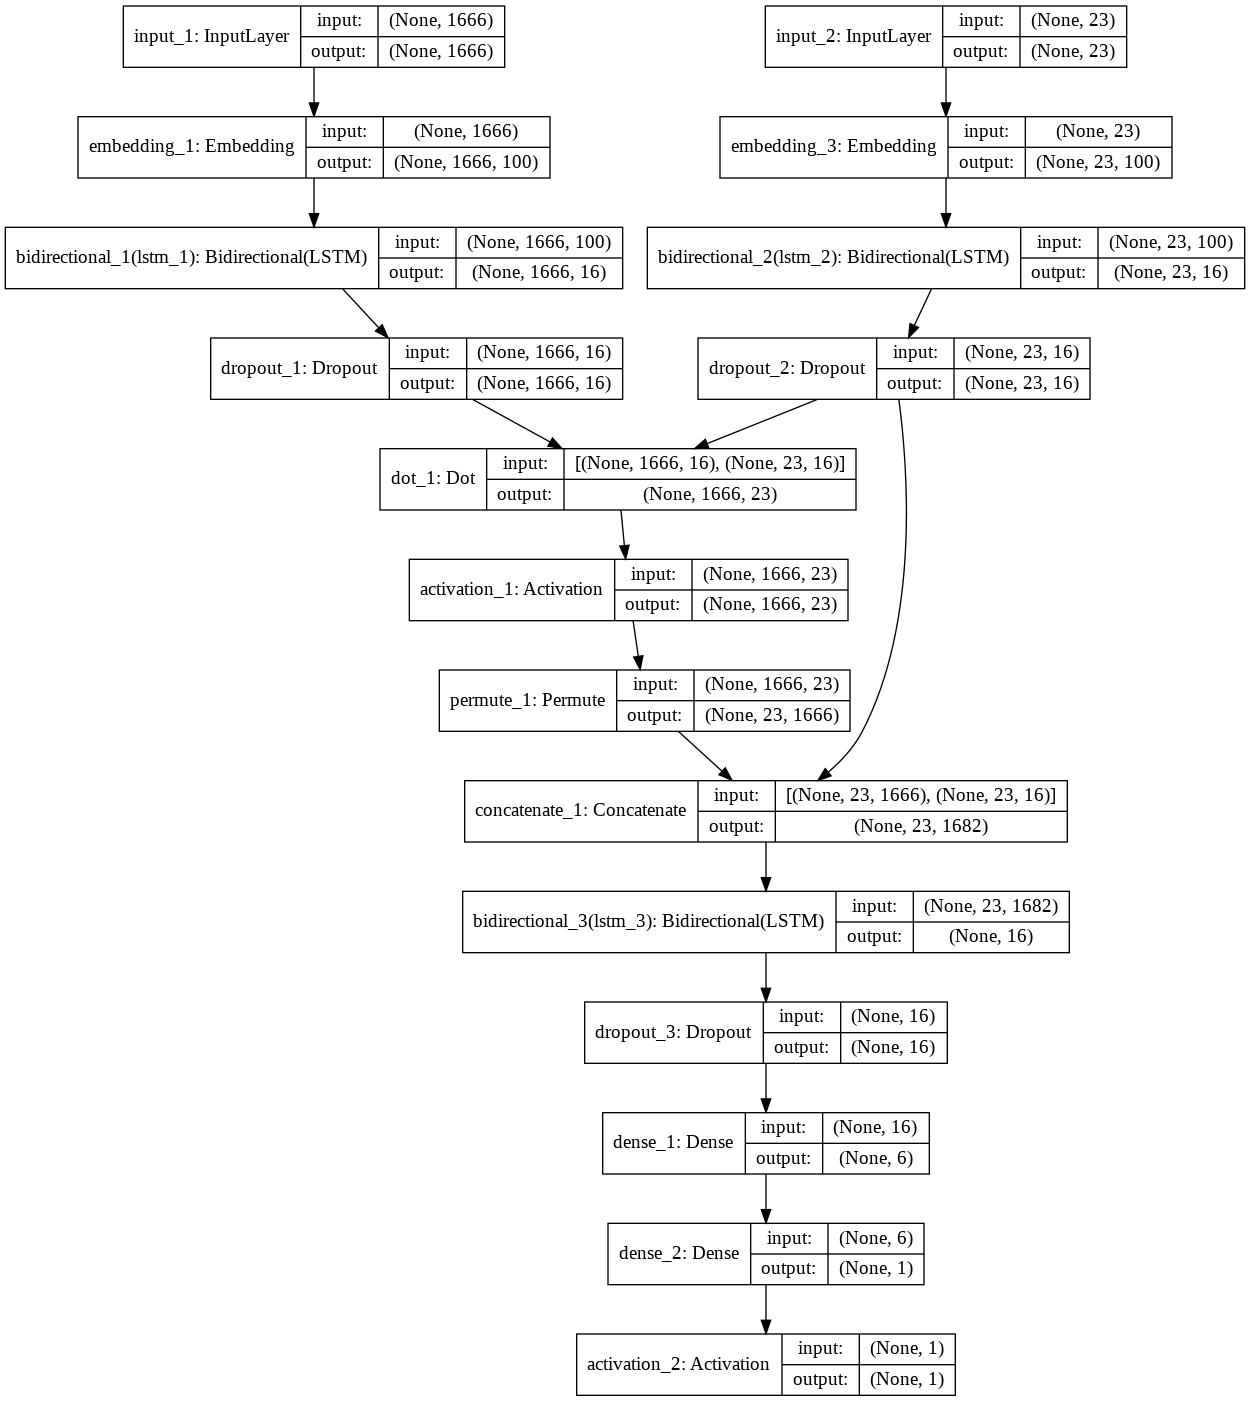

In [0]:
# plot graph
plot_model(model_binary, to_file='bAbI.png', show_shapes=True) 
display(Image(filename='bAbI.png'))

###One feature extraction

In [0]:
def create_binary_model_feature_extraction(embedding_feature_extraction_input_size, feature_extraction_embedding_dim):
  K.clear_session()
  
  #embedding layers
  embedding_layer_doc = Embedding(len(token_2_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_doc),
                            trainable=False)


  embedding_layer_input_q = Embedding(len(token_2_index_q) + 1,
                              Q_LEN)

  embedding_layer_q = Embedding(len(token_2_index_q) + 1,
                              EMBEDDING_DIM,
                              embeddings_initializer=Constant(embedding_matrix_q),
                              input_length=Q_LEN,
                              trainable=False)
  
  embedding_layer_feature_extraction = Embedding(embedding_feature_extraction_input_size,
                                         feature_extraction_embedding_dim) #all FEATURE EXTRACTION HAS SAME DIM AS WORD_MATCH_EMBEDDING_DIM
  
  #INPUT LAYERS FOR STROY AND QUERY

  # placeholders
  input_sequence = Input((DOC_LEN,))
  question = Input((Q_LEN,))
  input_feature_extraction_sequence = Input((DOC_LEN,))

  # INPUT ENCODER

  input_encoder_m = embedding_layer_doc(input_sequence)
  #input_encoder_m = Bidirectional(LSTM(16, return_sequences=True))(input_encoder_m)
  #input_encoder_m = Bidirectional(LSTM(8, return_sequences=True))(input_encoder_m)
  #input_encoder_m = Bidirectional(LSTM(4, return_sequences=True))(input_encoder_m)
  #input_encoder_m = Dropout(rate=0.2)(input_encoder_m)                            
  
  # output: (samples, story_maxlen, embedding_dim)
  
  # WORD MATCH / ANOTHER FEATURES
  feature_extraction_encoder_m = embedding_layer_feature_extraction(input_feature_extraction_sequence)


  # CONCAT
  input_concat = concatenate([input_encoder_m, feature_extraction_encoder_m])
  #input_concat = Bidirectional(LSTM(2, return_sequences=True))(input_concat)
  input_concat = Bidirectional(LSTM(8, return_sequences=True))(input_concat)
  #input_concat = Bidirectional(LSTM(8, return_sequences=True))(input_concat)
  input_concat = Dropout(rate=0.2)(input_concat)


  # QUESTION ENCODER
                                  
  question_encoder = embedding_layer_q(question)
  question_encoder = Dense(embedding_feature_extraction_input_size+feature_extraction_embedding_dim)(question_encoder)
  #question_encoder = Bidirectional(LSTM(16, return_sequences=True))(question_encoder)
  question_encoder = Bidirectional(LSTM(8, return_sequences=True))(question_encoder)
  #question_encoder = Bidirectional(LSTM(4, return_sequences=True))(question_encoder)
  question_encoder = Dropout(rate=0.2)(question_encoder) 

  # ATTENTION

  # encode input sequence and questions (which are indices)
  # to sequences of dense vectors
 
  # compute a 'match' between the first input vector sequence
  # and the question vector sequence
  # shape: `(samples, story_maxlen, query_maxlen)`
  #match = dot([input_encoded_m, question_encoded], axes=(2, 2)) #TODO: ATTENTION???
  match = dot([input_concat, question_encoder], axes=(2, 2))
  match = Activation('softmax')(match)


  # add the match matrix with the second input vector sequence
  #response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
  response = match
  response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

  
  # concatenate the match matrix with the question vector sequence
  #answer = concatenate([response, question_encoded])
  answer = concatenate([response, question_encoder])

  # the original paper uses a matrix multiplication for this reduction step.
  # we choose to use a RNN instead.
  #answer = LSTM(32)(answer)  # (samples, 32)
  #answer = Dropout(0.3)(answer)
  answer = Bidirectional(LSTM(8))(answer)  # (samples, 32)
  answer = Dropout(rate=0.2)(answer)


  # one regularization layer -- more would probably be needed.
  #answer = Dense(8)(answer)  # (samples, vocab_size)
  answer = Dense(6)(answer)  # (samples, vocab_size)
  answer = Dense(1)(answer)  # (samples, vocab_size)
  # we output a probability distribution over the vocabulary
  answer = Activation('sigmoid')(answer)

  

  # build the final model
  model_binary_feature_extraction = Model([input_sequence, input_feature_extraction_sequence, question], outputs=answer) #INPUT_SEQUENCE, QUESTION ARE INPUT LAYERS, ANSER ARE OUTPUT LAYER
  rmsprop = optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=1e-6)
  model_binary_feature_extraction.compile(optimizer=rmsprop, loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model_binary_feature_extraction

##Train Model Binary 1 - No Features extraction

In [0]:
#create_binary_model
K.clear_session()
model_binary = create_binary_model()

In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=20
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_binary.h5', save_best_only=True, monitor='loss', mode='min')

history_binary = model_binary.fit([data_doc, data_q], data_answer_binary,
          batch_size=512+256,
          epochs=100,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
2106/2106 [==============================] - 16s 8ms/step - loss: 0.8582 - acc: 0.5869
Epoch 2/100
2106/2106 [==============================] - 14s 7ms/step - loss: 0.6891 - acc: 0.5864
Epoch 3/100
2106/2106 [==============================] - 14s 7ms/step - loss: 0.6742 - acc: 0.5883
Epoch 4/100
2106/2106 [==============================] - 14s 7ms/step - loss: 0.6733 - acc: 0.5874
Epoch 5/100
2106/2106 [==============================] - 14s 6ms/step - loss: 0.6665 - acc: 0.5912
Epoch 6/100
2106/2106 [==============================] - 14s 7ms/step - loss: 0.6641 - acc: 0.5988
Epoch 7/100
2106/2106 [==============================] - 14s 6ms/step - loss: 0.6674 - acc: 0.5931
Epoch 8/100
2106/2106 [==============================] - 14s 6ms/step - loss: 0.6495 - acc: 0.6140
Epoch 9/100
2106/2106 [==============================] - 14s 7ms/step - loss: 0.6484 - acc: 0.6197
Epoch 10/100
2106/2106 [==============================] - 14s 7ms/step - loss: 0.6348 - acc: 0.6382
Epoch 11/

In [0]:
K.clear_session()

In [0]:

# save history
f = open('history_binary.pckl', 'wb')
pickle.dump(history_binary.history, f)
f.close()

In [0]:
#upload to Google drive
upload = upload_google_drive('history_binary.pckl')
print('{} with ID {}'.format('history_binary.pckl', upload.get('id')))

history_binary.pckl with ID 1JKrt4-WTLBMtO1sttxbyU-AYFiTJejo4


In [0]:
upload = upload_google_drive('model_binary.h5')
print('{} with ID {}'.format('model_binary.h5', upload.get('id')))

model_binary.h5 with ID 1VZExHQq_7_Tu90PwRTCofTuTJsiBQyOH


##Train Model Binary 2 -  Word Match

In [0]:
WORD_MATCH_EMBEDDING_DIM = 2
FEATURE_EXTRACTION_EMBEDDING_DIM = 2

In [0]:
#testing new function
K.clear_session()
model_binary_word_match = create_binary_model_feature_extraction(2,2) #since only 1 or 0

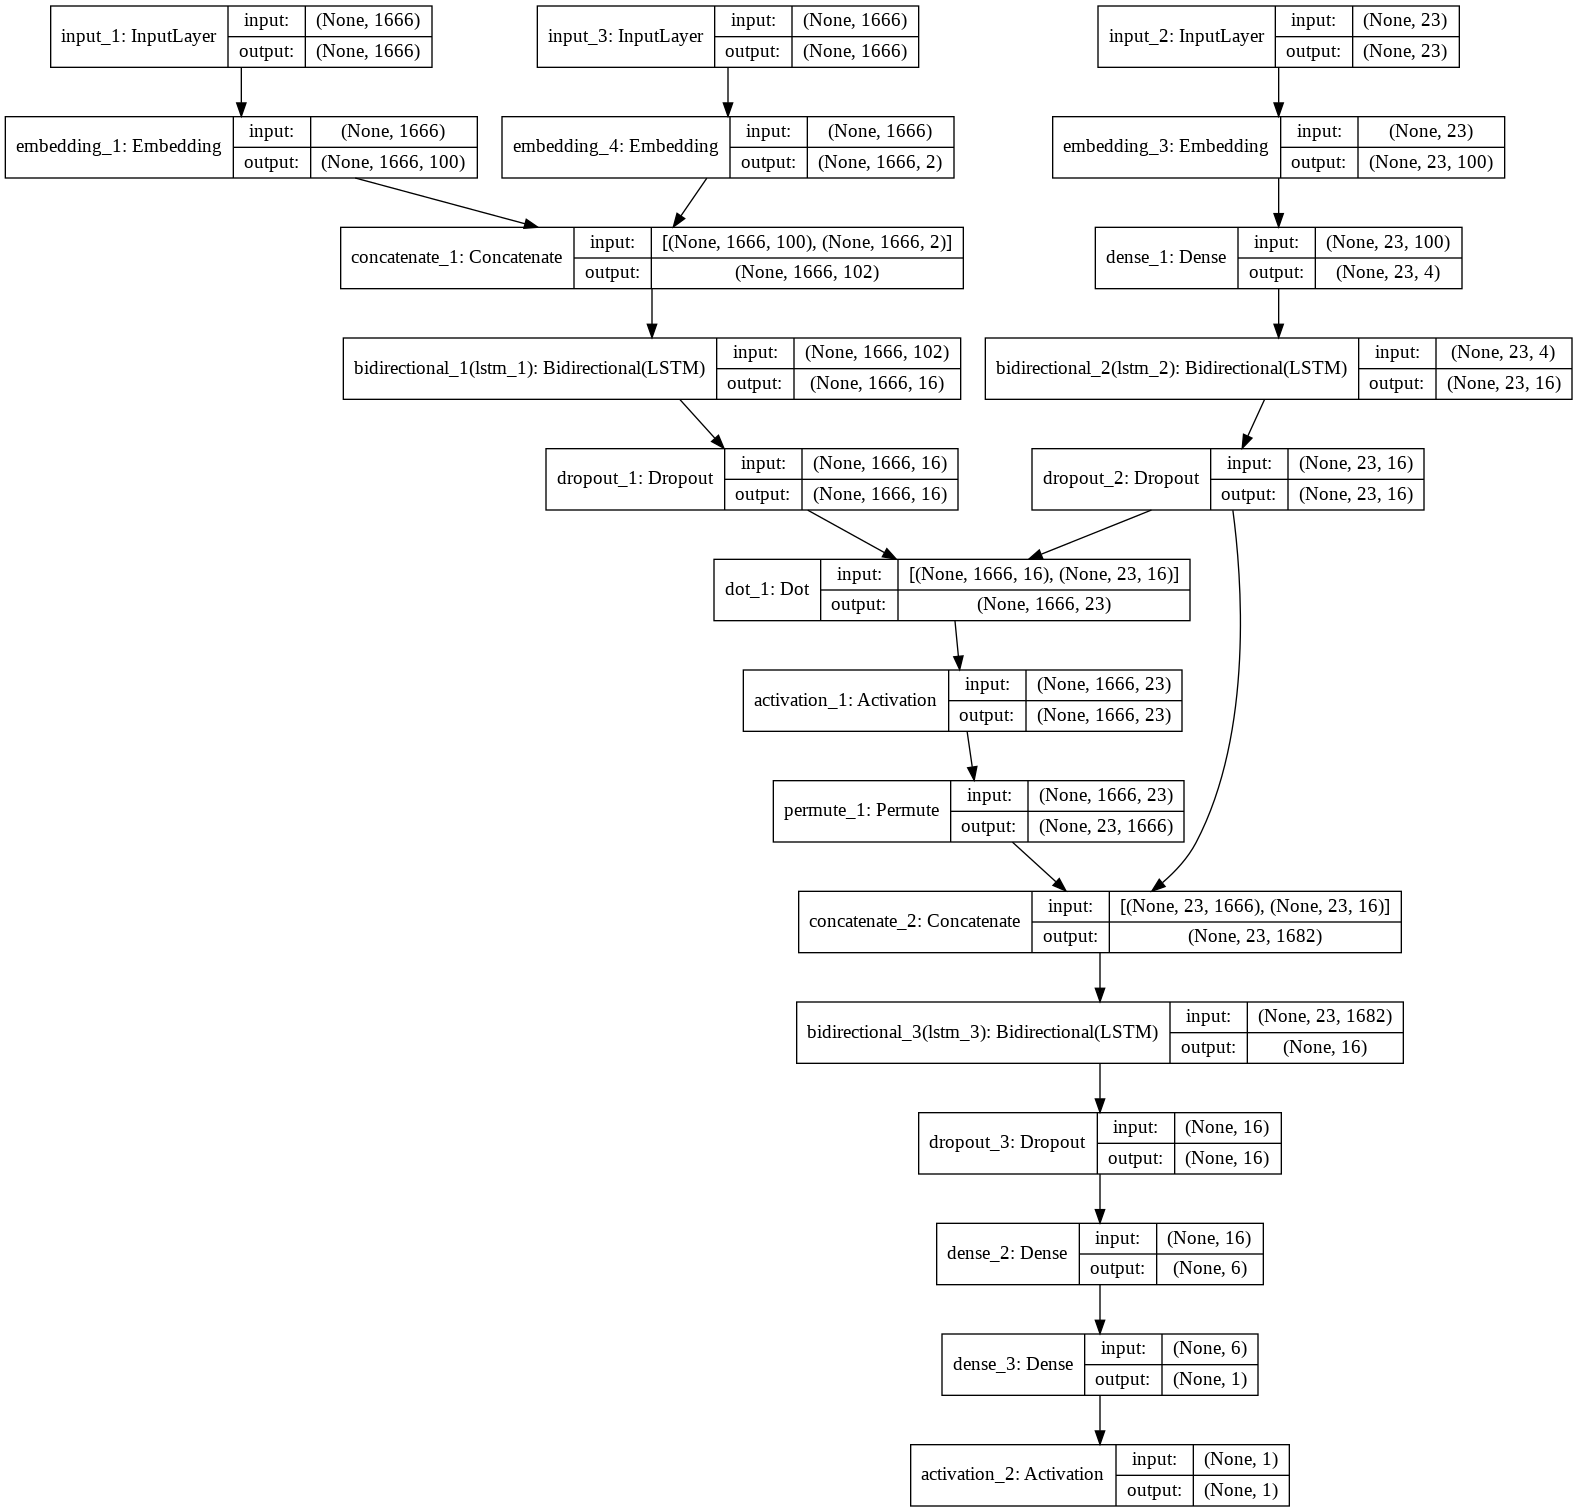

In [0]:
# plot graph
plot_model(model_binary_word_match, to_file='bAbI.png', show_shapes=True) 
display(Image(filename='bAbI.png'))

In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=20
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_binary_word_match.h5', save_best_only=True, monitor='loss', mode='min')

history_binary_word_match = model_binary_word_match.fit([data_doc, data_word_match ,data_q], data_answer_binary,
          batch_size=512+256,
          epochs=100,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
2106/2106 [==============================] - 20s 9ms/step - loss: 1.2173 - acc: 0.5864
Epoch 2/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.7074 - acc: 0.5670
Epoch 3/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6894 - acc: 0.5532
Epoch 4/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6839 - acc: 0.5726
Epoch 5/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6766 - acc: 0.5679
Epoch 6/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6696 - acc: 0.5840
Epoch 7/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6569 - acc: 0.5983
Epoch 8/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6690 - acc: 0.5878
Epoch 9/100
2106/2106 [==============================] - 16s 7ms/step - loss: 0.6558 - acc: 0.6078
Epoch 10/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6505 - acc: 0.6135
Epoch 11/

In [0]:
K.clear_session()

In [0]:
# save history
f = open('history_binary_word_match.pckl', 'wb')
pickle.dump(history_binary_word_match.history, f)
f.close()

In [0]:
#upload to Google drive
upload = upload_google_drive('history_binary_word_match.pckl')
print('{} with ID {}'.format('history_binary_word_match.pckl', upload.get('id')))

history_binary_word_match.pckl with ID 1v2PXNEhMZejPvOlCGNZzqd9TPfoI1MTZ


In [0]:
upload = upload_google_drive('model_binary_word_match.h5')
print('{} with ID {}'.format('model_binary_word_match.h5', upload.get('id')))

model_binary_word_match.h5 with ID 1VllUrYB8_V6v78cmEdCGP1P-hsV7X6uy


##Train Binary 3 - POS TAG

In [0]:
#create_binary_model
K.clear_session()
model_binary_pos = create_binary_model_feature_extraction(64,10)

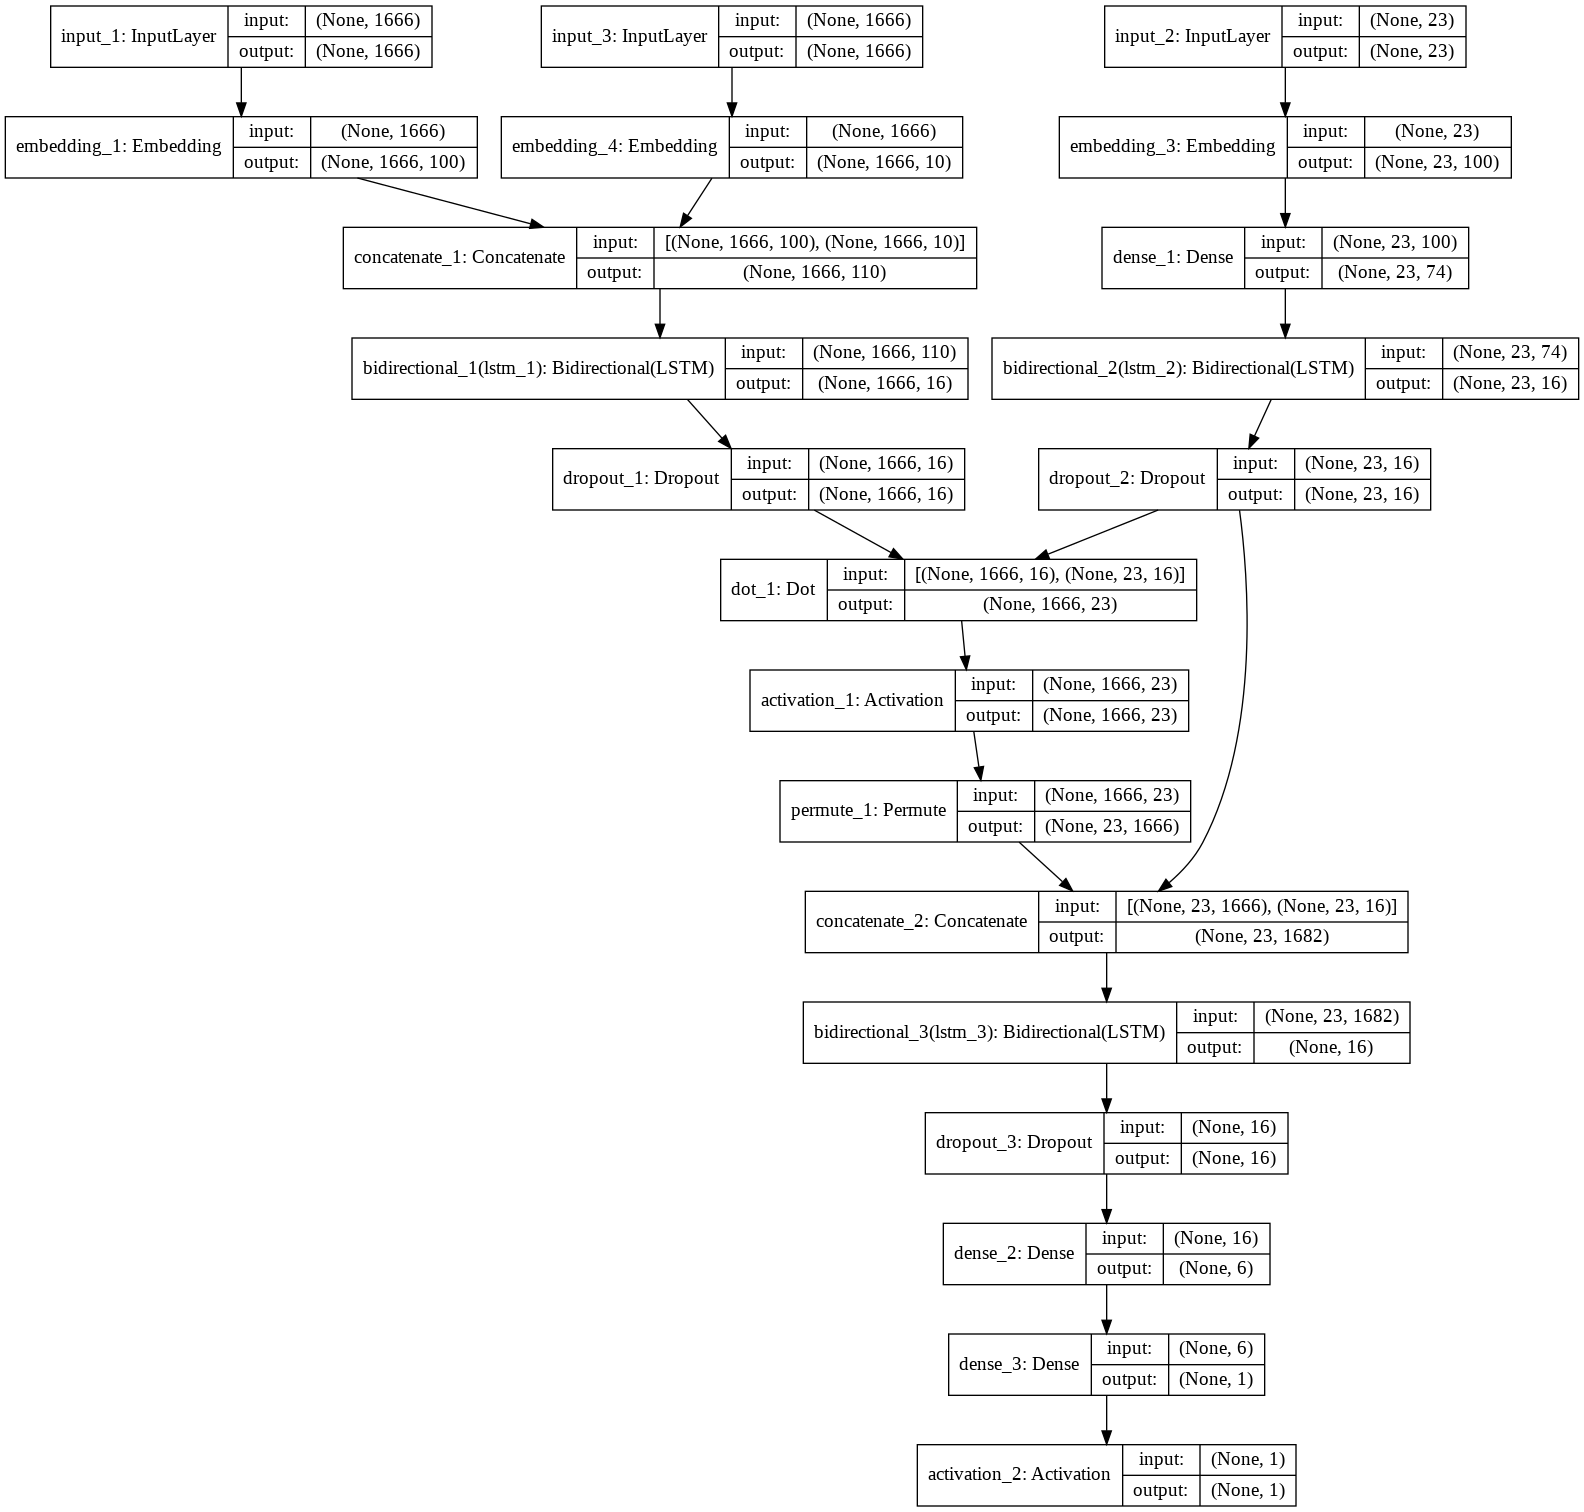

In [0]:
# plot graph
plot_model(model_binary_pos, to_file='bAbI.png', show_shapes=True) 
display(Image(filename='bAbI.png'))

In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=20
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_binary_pos.h5', save_best_only=True, monitor='loss', mode='min')

history_binary_pos = model_binary_pos.fit([data_doc, data_pos ,data_q], data_answer_binary,
          batch_size=512+256,
          epochs=100,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6771 - acc: 0.5774
Epoch 2/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6720 - acc: 0.5897
Epoch 3/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6641 - acc: 0.5950
Epoch 4/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6566 - acc: 0.6045
Epoch 5/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6511 - acc: 0.6106
Epoch 6/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6470 - acc: 0.6135
Epoch 7/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6309 - acc: 0.6396
Epoch 8/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6249 - acc: 0.6472
Epoch 9/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6218 - acc: 0.6614
Epoch 10/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.5996 - acc: 0.6743
Epoch 11/

In [0]:
K.clear_session()

In [0]:
# save history
f = open('history_binary_pos.pckl', 'wb')
pickle.dump(history_binary_pos.history, f)
f.close()

In [0]:
#upload to Google drive
upload = upload_google_drive('history_binary_pos.pckl')
print('{} with ID {}'.format('history_binary_pos.pckl', upload.get('id')))

history_binary_pos.pckl with ID 1xfOR63B2hMfP4x0wLeGmyNqEusTB8ERj


In [0]:
upload = upload_google_drive('model_binary_pos.h5')
print('{} with ID {}'.format('model_binary_pos.h5', upload.get('id')))

model_binary_pos.h5 with ID 10f6JOw0YBWSoMincvhw15-meGgOXQpIX


##Train Binary 4 - TF-IDF

In [0]:
#create_binary_model
K.clear_session()
model_binary_tf = create_binary_model_feature_extraction(1666,10)

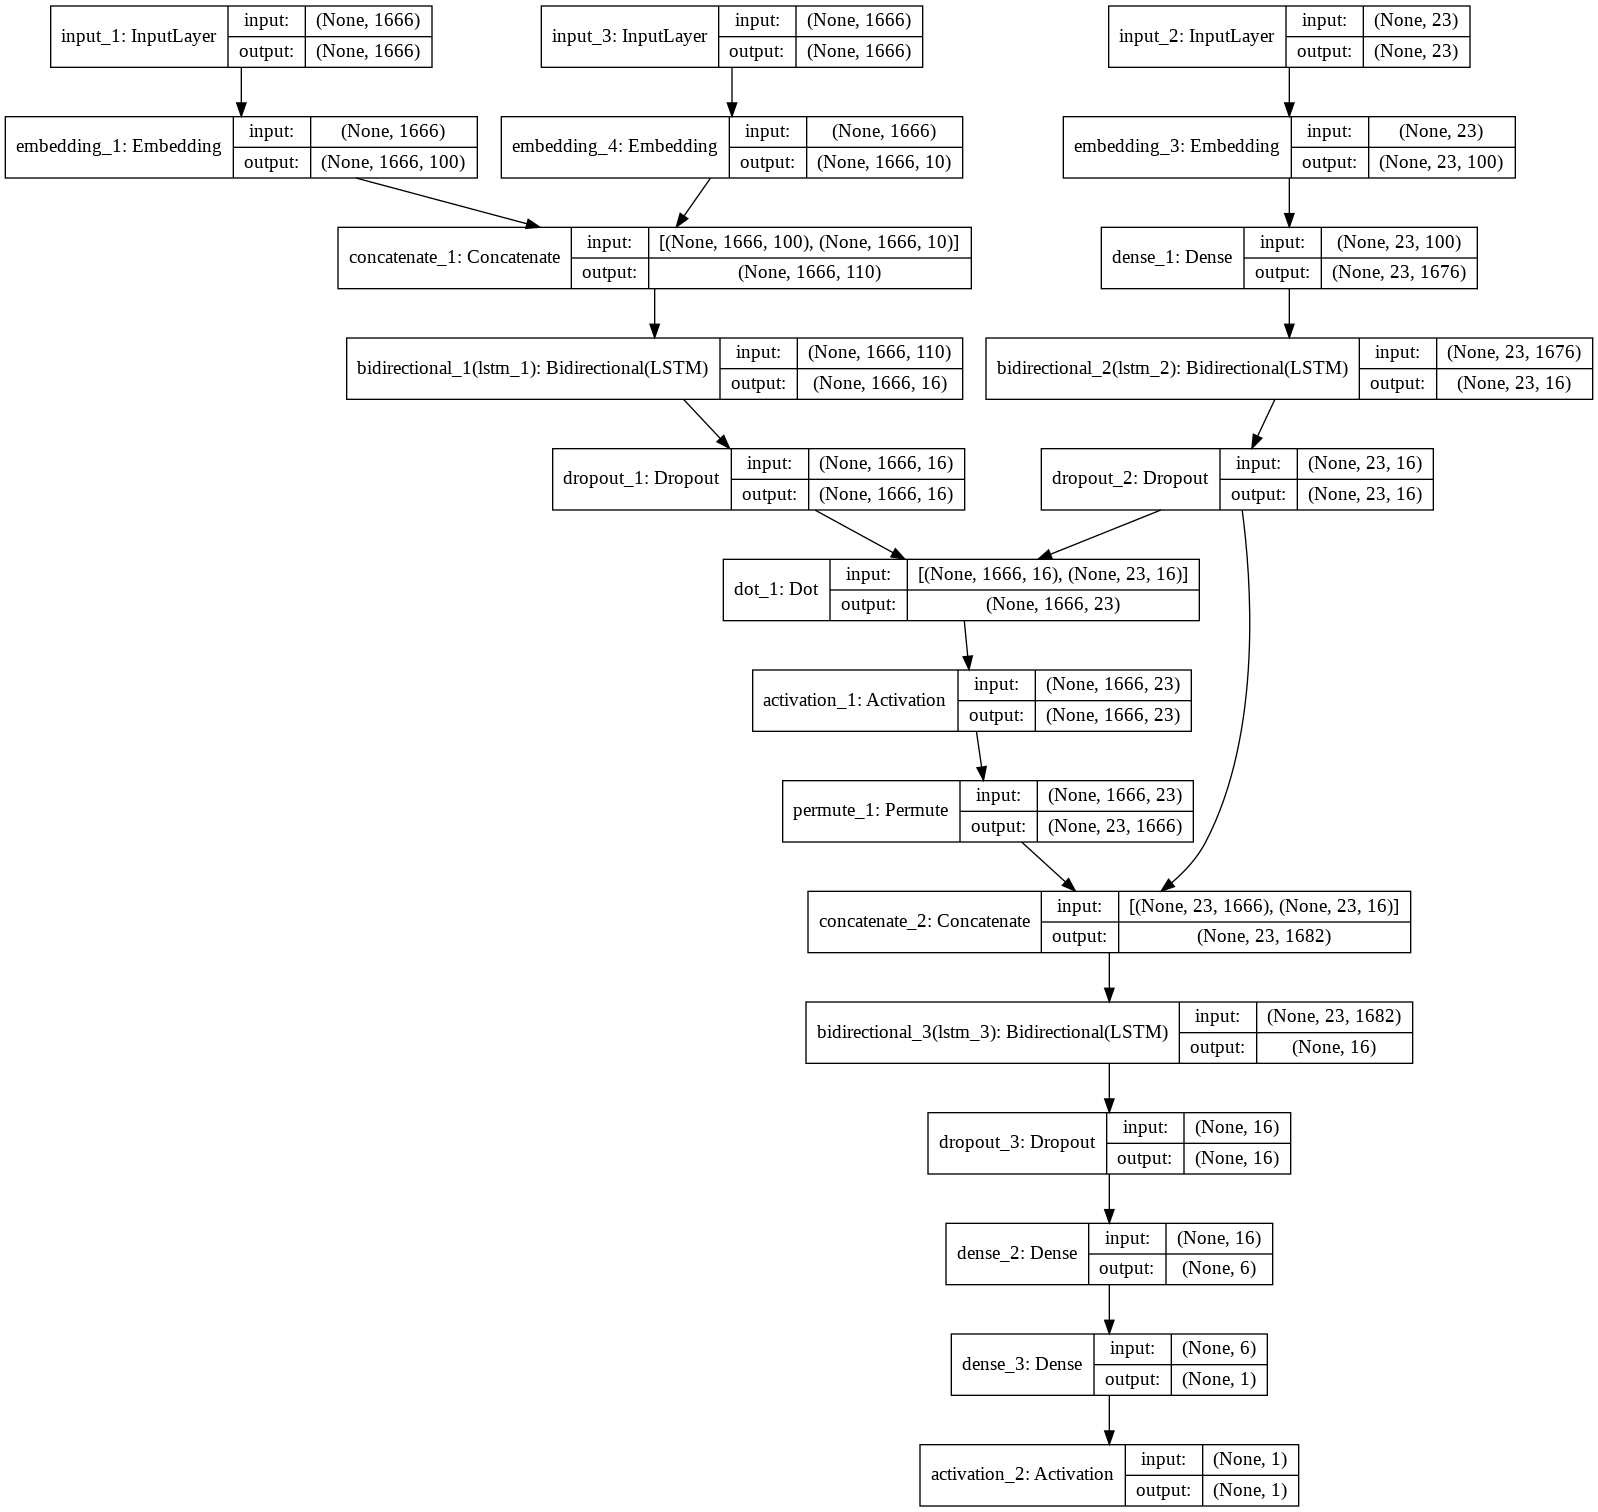

In [0]:
# plot graph
plot_model(model_binary_tf, to_file='bAbI.png', show_shapes=True) 
display(Image(filename='bAbI.png'))

In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=20
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_binary_tf.h5', save_best_only=True, monitor='loss', mode='min')

history_binary_tf = model_binary_tf.fit([data_doc, data_tf ,data_q], data_answer_binary,
          batch_size=512+256,
          epochs=100,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
2106/2106 [==============================] - 19s 9ms/step - loss: 0.7719 - acc: 0.5071
Epoch 2/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6794 - acc: 0.5731
Epoch 3/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6816 - acc: 0.5793
Epoch 4/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6807 - acc: 0.5864
Epoch 5/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6702 - acc: 0.5931
Epoch 6/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6718 - acc: 0.5883
Epoch 7/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6614 - acc: 0.6035
Epoch 8/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6527 - acc: 0.6187
Epoch 9/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6691 - acc: 0.6092
Epoch 10/100
2106/2106 [==============================] - 15s 7ms/step - loss: 0.6553 - acc: 0.5893
Epoch 11/

In [0]:
K.clear_session()

In [0]:
# save history
f = open('history_binary_tf.pckl', 'wb')
pickle.dump(history_binary_tf.history, f)
f.close()

In [0]:
#upload to Google drive
upload = upload_google_drive('history_binary_tf.pckl')
print('{} with ID {}'.format('history_binary_tf.pckl', upload.get('id')))

history_binary_tf.pckl with ID 1DGVaP_OOWRNwRRVBmPdD5iskFuZIinMa


In [0]:
upload = upload_google_drive('model_binary_tf.h5')
print('{} with ID {}'.format('model_binary_tf.h5', upload.get('id')))

model_binary_tf.h5 with ID 1az7cReWDnLKj1mLfzXzmZU_mUa4_gOXS


#Model - with answer only - EXCLUDE feature extraction 

##Define Model architecture

In [0]:
K.clear_session()

In [0]:
embedding_layer_doc_1 = Embedding(len(token_2_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_doc),
                            #input_length=DOC_LEN,
                            trainable=False)


embedding_layer_input_q_1 = Embedding(len(token_2_index_q) + 1,
                            Q_LEN)

embedding_layer_q_1 = Embedding(len(token_2_index_q) + 1,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix_q],
                            embeddings_initializer=Constant(embedding_matrix_q),
                            input_length=Q_LEN,
                            trainable=False)

In [0]:
#INPUT LAYERS FOR STROY AND QUERY

# placeholders
input_sequence_1 = Input((DOC_LEN,))
question_1 = Input((Q_LEN,))


# INPUT ENCODER

# embed the input sequence into a sequence of vectors
input_encoder_m_1 = Sequential()
input_encoder_m_1.add(embedding_layer_doc_1) #STORY INPUT
#input_encoder_m_1.add(Bidirectional(LSTM(32, return_sequences=True)))

input_encoder_m_1.add(Dropout(rate=0.2))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c_1 = Sequential()
input_encoder_c_1.add(embedding_layer_input_q_1) #QUERY INPUT
input_encoder_c_1.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)


# QUESTION ENCODER
#TODO: WHY WE NEED BOTH INPUT ENCODER C AND QUESTION ENCODER??


# embed the question into a sequence of vectors
question_encoder_1 = Sequential()
question_encoder_1.add(embedding_layer_q_1) #TODO: WHY IS OUTPUT DIM == 64??
#question_encoder_1.add(Bidirectional(LSTM(32, return_sequences=True)))
question_encoder_1.add(Dropout(rate =0.2))
# output: (samples, query_maxlen, embedding_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:

# ATTENTION

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m_1 = input_encoder_m_1(input_sequence_1)

input_encoded_c_1 = input_encoder_c_1(input_sequence_1)
question_encoded_1 = question_encoder_1(question_1)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match_1 = dot([input_encoded_m_1, question_encoded_1], axes=(2, 2)) #TODO: ATTENTION???
match_1 = Activation('softmax')(match_1)


# add the match matrix with the second input vector sequence
response_1 = add([match_1, input_encoded_c_1])  # (samples, story_maxlen, query_maxlen)
#response_1 = match_1
response_1 = Permute((2, 1))(response_1)  # (samples, query_maxlen, story_maxlen)


In [0]:

# concatenate the match matrix with the question vector sequence
answer_1 = concatenate([response_1, question_encoded_1])

# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer_1 = Bidirectional(LSTM(32, return_sequences=True))(answer_1)  # (samples, 32)
answer_1 = Dropout(rate=0.2)(answer_1)
# one regularization layer -- more would probably be needed.

answer_start_1 = Bidirectional(LSTM(8))(answer_1)
answer_start_1 = Dropout(rate=0.2)(answer_start_1)
answer_start_1 = Dense(DOC_LEN)(answer_start_1 )  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer_start_1 = Activation('softmax')(answer_start_1)

# one regularization layer -- more would probably be needed.
answer_end_1 = Bidirectional(LSTM(8))(answer_1)
answer_end_1 = Dropout(rate=0.2)(answer_end_1)
answer_end_1 = Dense(DOC_LEN)(answer_end_1)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer_end_1 = Activation('softmax')(answer_end_1)


In [0]:


# build the final model
model_1 = Model([input_sequence_1, question_1], outputs=[answer_start_1, answer_end_1]) #INPUT_SEQUENCE, QUESTION ARE INPUT LAYERS, ANSER ARE OUTPUT LAYER
#rmsprop_1 = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=1e-6)
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

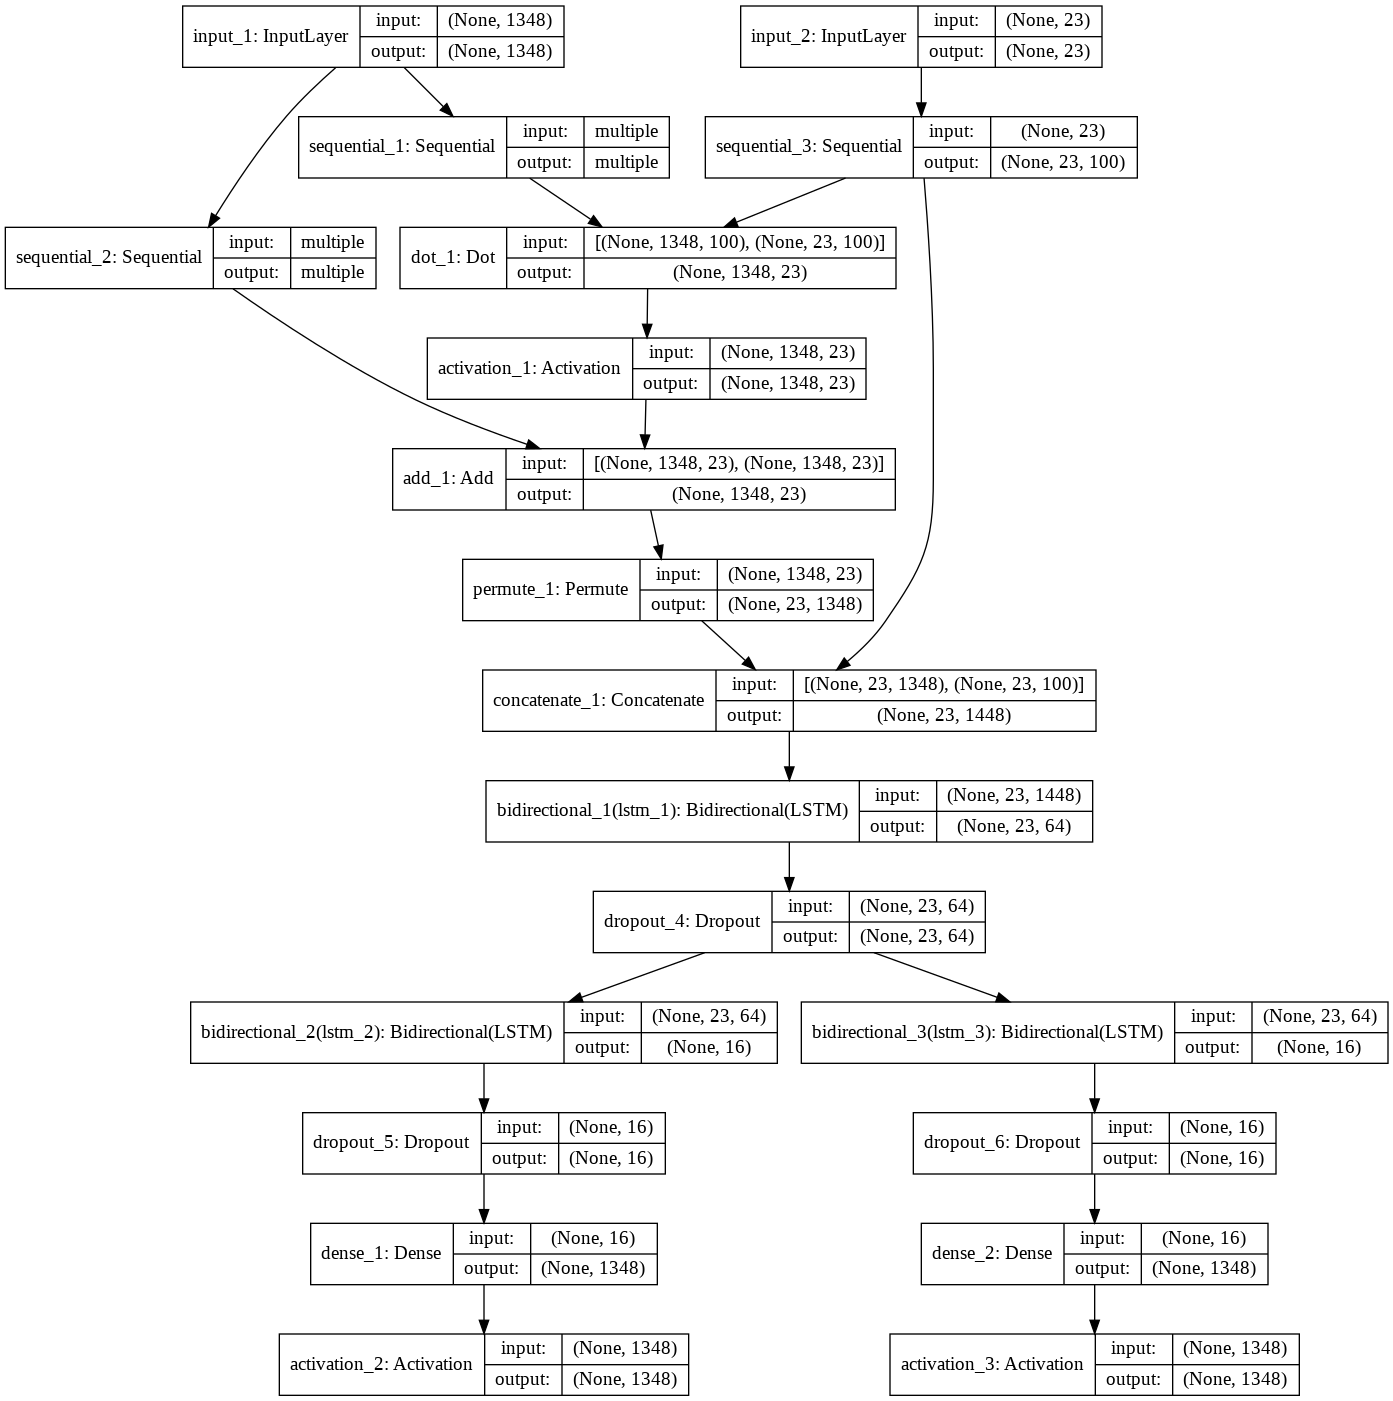

In [0]:
# plot graph
plot_model(model_1, to_file='bAbI.png', show_shapes=True) #SEQ1: INPUT_SEQ_M
display(Image(filename='bAbI.png'))

In [0]:
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1348)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 23)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             3692700     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 23, 100)      489100      input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

##Train Model

In [0]:
data_doc_with_ans = np.concatenate((x_doc_train_with_ans, x_doc_val_with_ans))
data_q_with_ans = np.concatenate((x_q_train_with_ans, x_q_val_with_ans))

data_answer_start_with_ans = np.concatenate((y_train_start_with_ans, y_val_start_with_ans))
data_answer_end_with_ans = np.concatenate((y_train_end_with_ans, y_val_end_with_ans))

In [0]:
# train the model
#early_stopping  = EarlyStopping(monitor='val_loss',
#                              patience=10
#                              , mode='auto')
#model_checkpoint = ModelCheckpoint('model_binary.h5', save_best_only=True, monitor='val_loss', mode='min')

history_1 = model_1.fit([data_doc_with_ans, data_q_with_ans], [data_answer_start_with_ans, data_answer_end_with_ans],
                        batch_size=128,
          epochs=10)#, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
865/865 [==============================] - 2s 2ms/step - loss: 11.5049 - activation_2_loss: 5.8540 - activation_3_loss: 5.6508 - activation_2_acc: 0.0046 - activation_3_acc: 0.0728
Epoch 2/10
865/865 [==============================] - 2s 2ms/step - loss: 11.4729 - activation_2_loss: 5.8401 - activation_3_loss: 5.6329 - activation_2_acc: 0.0081 - activation_3_acc: 0.0728
Epoch 3/10
865/865 [==============================] - 2s 2ms/step - loss: 11.4573 - activation_2_loss: 5.8389 - activation_3_loss: 5.6184 - activation_2_acc: 0.0092 - activation_3_acc: 0.0728
Epoch 4/10
865/865 [==============================] - 2s 2ms/step - loss: 11.4525 - activation_2_loss: 5.8260 - activation_3_loss: 5.6265 - activation_2_acc: 0.0046 - activation_3_acc: 0.0728
Epoch 5/10
865/865 [==============================] - 2s 2ms/step - loss: 11.4434 - activation_2_loss: 5.8206 - activation_3_loss: 5.6228 - activation_2_acc: 0.0092 - activation_3_acc: 0.0728
Epoch 6/10
865/865 [====================

KeyboardInterrupt: ignored

##Save Trained Model and History

#Model  - with answer only - with Feature Extractions

In [0]:
WORD_MATCH_EMBEDDING_DIM = 10

##Define Model

###Model- old

In [0]:
def create_tokens_model_with_feature_extraction():
  K.clear_session()

  embedding_layer_doc_2 = Embedding(len(token_2_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_doc),
                            #input_length=DOC_LEN,
                            trainable=False)


  embedding_layer_input_q_2 = Embedding(len(token_2_index_q) + 1,
                            Q_LEN)

  embedding_layer_q_2 = Embedding(len(token_2_index_q) + 1,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix_q],
                            embeddings_initializer=Constant(embedding_matrix_q),
                            input_length=Q_LEN,
                            trainable=False)

  embedding_layer_word_match_2 = Embedding(len(token_2_index_q) + 1,
                                         WORD_MATCH_EMBEDDING_DIM
                            )

  #INPUT LAYERS FOR STROY AND QUERY

  # placeholders
  input_sequence_2 = Input((DOC_LEN,))
  question_2 = Input((Q_LEN,))
  input_word_match_sequence_2 = Input((DOC_LEN,))


  # INPUT ENCODER
  # embed the input sequence into a sequence of vectors
  input_encoder_m_2 = embedding_layer_doc_2(input_sequence_2)
  
  # output: (samples, story_maxlen, embedding_dim)

  #Word Match 
  word_match_encoder_m_2 = embedding_layer_word_match_2(input_word_match_sequence_2)

  # QUESTION ENCODER


  # embed the question into a sequence of vectors
  question_encoder_2 = embedding_layer_q_2(question_2)
  question_encoder_2 = Dense(EMBEDDING_DIM+WORD_MATCH_EMBEDDING_DIM)(question_encoder_2)
  #question_encoder_2 = Bidirectional(LSTM(2, return_sequences=True))(question_encoder_2)
  #question_encoder_2 = Bidirectional(LSTM(8, return_sequences=True))(question_encoder_2)
  #question_encoder_2 = Bidirectional(LSTM(8, return_sequences=True))(question_encoder_2)
  question_encoder_2 = Dropout(rate=0.2)(question_encoder_2)


  #concat
  input_concat_2 = concatenate([input_encoder_m_2, word_match_encoder_m_2])
  #input_concat_2 = Bidirectional(LSTM(2, return_sequences=True))(input_concat_2)
  #input_concat_2 = Bidirectional(LSTM(8, return_sequences=True))(input_concat_2)
  #input_concat_2 = Bidirectional(LSTM(8, return_sequences=True))(input_concat_2)
  input_concat_2 = Dropout(rate=0.2)(input_concat_2)


  # ATTENTION


  # compute a 'match' between the first input vector sequence
  # and the question vector sequence
  # shape: `(samples, story_maxlen, query_maxlen)`
  #match_2 = dot([input_encoded_m_2, question_encoded_2], axes=(2, 2)) #TODO: ATTENTION???

  match_2 = dot([input_concat_2, question_encoder_2], axes=(2, 2))
  match_2 = Activation('softmax')(match_2)


  # add the match matrix with the second input vector sequence
  #response_2 = add([match_2, input_encoded_c_2])  # (samples, story_maxlen, query_maxlen)
  response_2 = match_2
  response_2 = Permute((2, 1))(response_2)  # (samples, query_maxlen, story_maxlen)


  # concatenate the match matrix with the question vector sequence
  answer_2 = concatenate([response_2, question_encoder_2])




  # the original paper uses a matrix multiplication for this reduction step.
  # we choose to use a RNN instead.
  answer_2 = Bidirectional(LSTM(8))(answer_2)  # (samples, 32)

  # one regularization layer -- more would probably be needed.
  #answer_start_2 = Dropout(rate=0.2)(answer_2)
  #answer_start_2 = Dense(DOC_LEN)(answer_start_2 )  # (samples, vocab_size)
  answer_start_2 = Dense(DOC_LEN)(answer_2)

  # we output a probability distribution over the vocabulary
  answer_start_2 = Activation('softmax')(answer_start_2)

  # one regularization layer -- more would probably be needed.
  #answer_end_2 = Dropout(rate=0.2)(answer_2)
  #answer_end_2 = Dense(DOC_LEN)(answer_end_2)  # (samples, vocab_size)
  answer_end_2 = Dense(DOC_LEN)(answer_2)  # (samples, vocab_size)

  # we output a probability distribution over the vocabulary
  answer_end_2 = Activation('softmax')(answer_end_2)



  # build the final model
  model_2 = Model([input_sequence_2, input_word_match_sequence_2, question_2], outputs=[answer_start_2, answer_end_2]) #INPUT_SEQUENCE, QUESTION ARE INPUT LAYERS, ANSER ARE OUTPUT LAYER
  rmsprop_2 = optimizers.RMSprop(lr=0.0075, rho=0.9, epsilon=None, decay=1e-6)
  model_2.compile(optimizer=rmsprop_2, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model_2


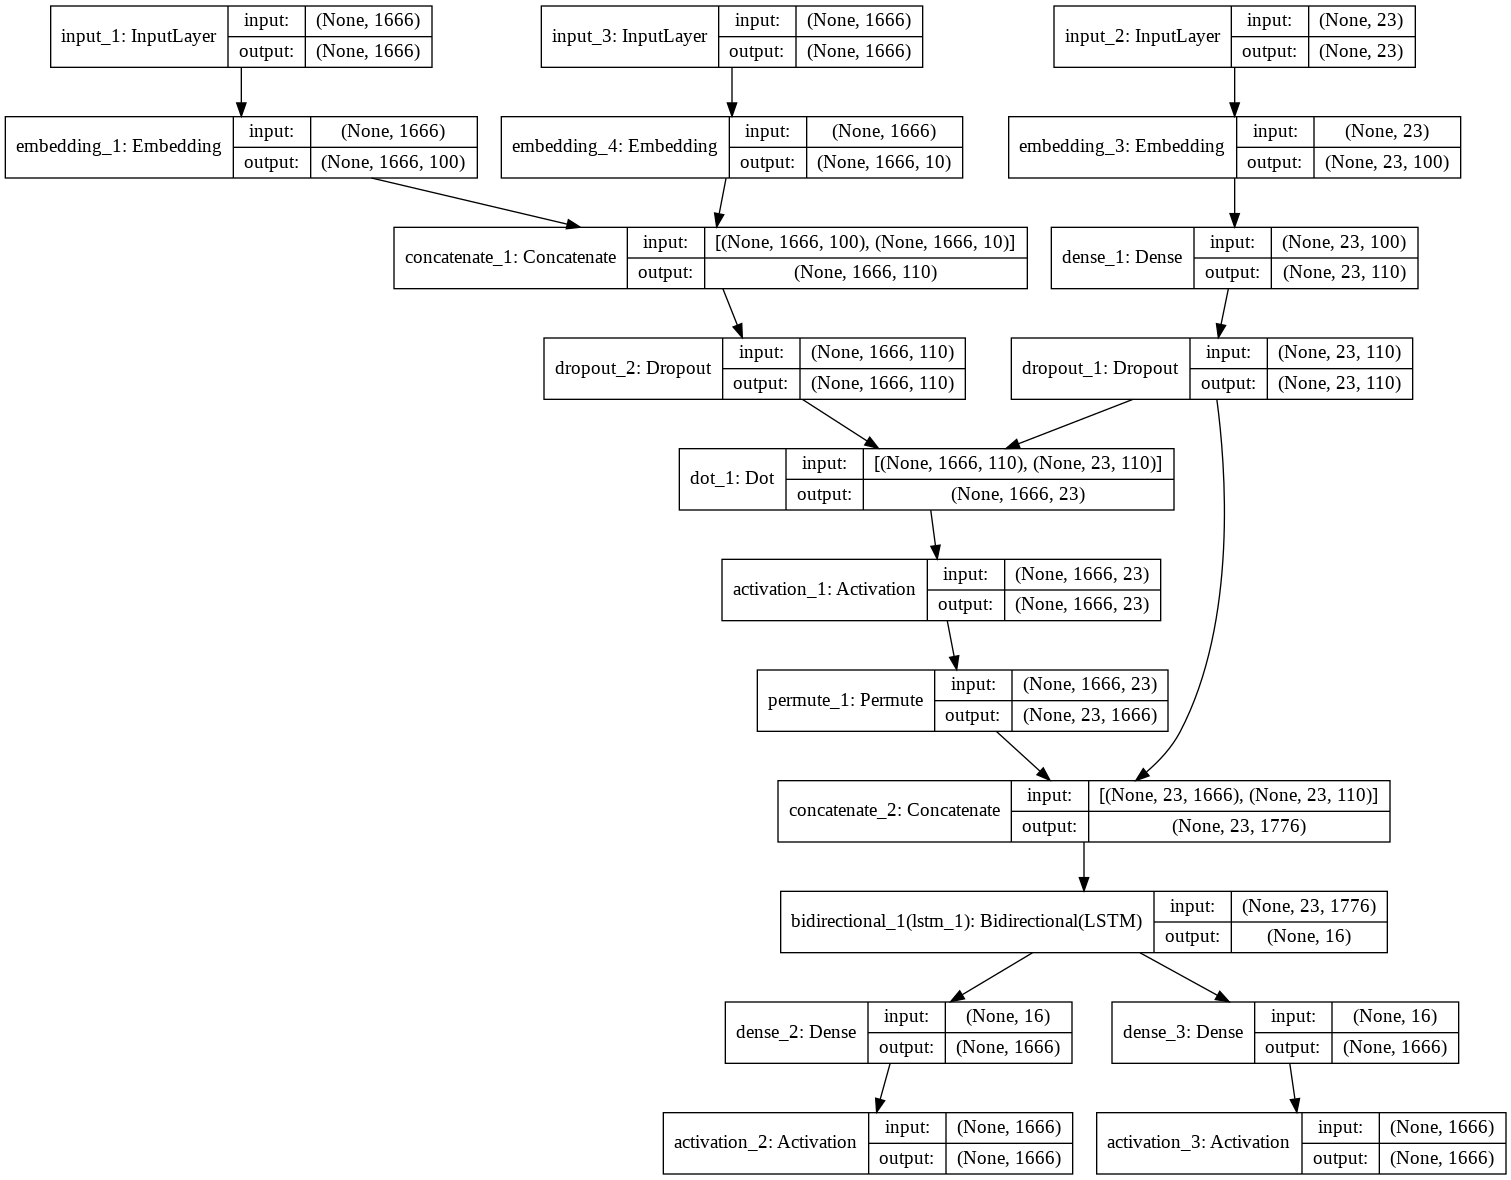

In [0]:
model_tokens_word_match = create_tokens_model_with_feature_extraction()

# plot graph
plot_model(model_tokens_word_match, to_file='bAbI.png', show_shapes=True) 
display(Image(filename='bAbI.png'))

In [0]:
model_tokens_word_match.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1666)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1666)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 23)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1666, 100)    3692700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

###Model - new

In [0]:
def create_tokens_model_with_feature_extraction_new(embedding_feature_extraction_input_size, feature_extraction_embedding_dim):
  K.clear_session()

  embedding_layer_doc_2 = Embedding(len(token_2_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_doc),
                            #input_length=DOC_LEN,
                            trainable=False)


  embedding_layer_input_q_2 = Embedding(len(token_2_index_q) + 1,
                            Q_LEN)

  embedding_layer_q_2 = Embedding(len(token_2_index_q) + 1,
                            EMBEDDING_DIM,
                            #weights=[embedding_matrix_q],
                            embeddings_initializer=Constant(embedding_matrix_q),
                            input_length=Q_LEN,
                            trainable=False)

  embedding_layer_feature_extraction_2 = Embedding(embedding_feature_extraction_input_size,
                                         feature_extraction_embedding_dim
                            )

  #INPUT LAYERS FOR STROY AND QUERY

  # placeholders
  input_sequence_2 = Input((DOC_LEN,))
  question_2 = Input((Q_LEN,))
  input_feature_extraction_sequence_2 = Input((DOC_LEN,))


  # INPUT ENCODER
  # embed the input sequence into a sequence of vectors
  input_encoder_m_2 = embedding_layer_doc_2(input_sequence_2)
  
  # output: (samples, story_maxlen, embedding_dim)

  #Word Match 
  word_match_encoder_m_2 = embedding_layer_feature_extraction_2(input_feature_extraction_sequence_2)

  # QUESTION ENCODER


  # embed the question into a sequence of vectors
  question_encoder_2 = embedding_layer_q_2(question_2)
  question_encoder_2 = Dense(EMBEDDING_DIM+feature_extraction_embedding_dim)(question_encoder_2)
  #question_encoder_2 = Bidirectional(LSTM(2, return_sequences=True))(question_encoder_2)
  #question_encoder_2 = Bidirectional(LSTM(8, return_sequences=True))(question_encoder_2)
  #question_encoder_2 = Bidirectional(LSTM(8, return_sequences=True))(question_encoder_2)
  question_encoder_2 = Dropout(rate=0.2)(question_encoder_2)


  #concat
  input_concat_2 = concatenate([input_encoder_m_2, word_match_encoder_m_2])
  #input_concat_2 = Bidirectional(LSTM(2, return_sequences=True))(input_concat_2)
  #input_concat_2 = Bidirectional(LSTM(8, return_sequences=True))(input_concat_2)
  #input_concat_2 = Bidirectional(LSTM(8, return_sequences=True))(input_concat_2)
  input_concat_2 = Dropout(rate=0.2)(input_concat_2)


  # ATTENTION


  # compute a 'match' between the first input vector sequence
  # and the question vector sequence
  # shape: `(samples, story_maxlen, query_maxlen)`
  #match_2 = dot([input_encoded_m_2, question_encoded_2], axes=(2, 2)) #TODO: ATTENTION???

  match_2 = dot([input_concat_2, question_encoder_2], axes=(2, 2))
  match_2 = Activation('softmax')(match_2)


  # add the match matrix with the second input vector sequence
  #response_2 = add([match_2, input_encoded_c_2])  # (samples, story_maxlen, query_maxlen)
  response_2 = match_2
  response_2 = Permute((2, 1))(response_2)  # (samples, query_maxlen, story_maxlen)


  # concatenate the match matrix with the question vector sequence
  answer_2 = concatenate([response_2, question_encoder_2])




  # the original paper uses a matrix multiplication for this reduction step.
  # we choose to use a RNN instead.
  answer_2 = Bidirectional(LSTM(8))(answer_2)  # (samples, 32)

  # one regularization layer -- more would probably be needed.
  #answer_start_2 = Dropout(rate=0.2)(answer_2)
  #answer_start_2 = Dense(DOC_LEN)(answer_start_2 )  # (samples, vocab_size)
  answer_start_2 = Dense(DOC_LEN)(answer_2)

  # we output a probability distribution over the vocabulary
  answer_start_2 = Activation('softmax')(answer_start_2)

  # one regularization layer -- more would probably be needed.
  #answer_end_2 = Dropout(rate=0.2)(answer_2)
  #answer_end_2 = Dense(DOC_LEN)(answer_end_2)  # (samples, vocab_size)
  answer_end_2 = Dense(DOC_LEN)(answer_2)  # (samples, vocab_size)

  # we output a probability distribution over the vocabulary
  answer_end_2 = Activation('softmax')(answer_end_2)



  # build the final model
  model_2 = Model([input_sequence_2, input_feature_extraction_sequence_2, question_2], outputs=[answer_start_2, answer_end_2]) #INPUT_SEQUENCE, QUESTION ARE INPUT LAYERS, ANSER ARE OUTPUT LAYER
  rmsprop_2 = optimizers.RMSprop(lr=0.0075, rho=0.9, epsilon=None, decay=1e-6)
  model_2.compile(optimizer=rmsprop_2, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model_2


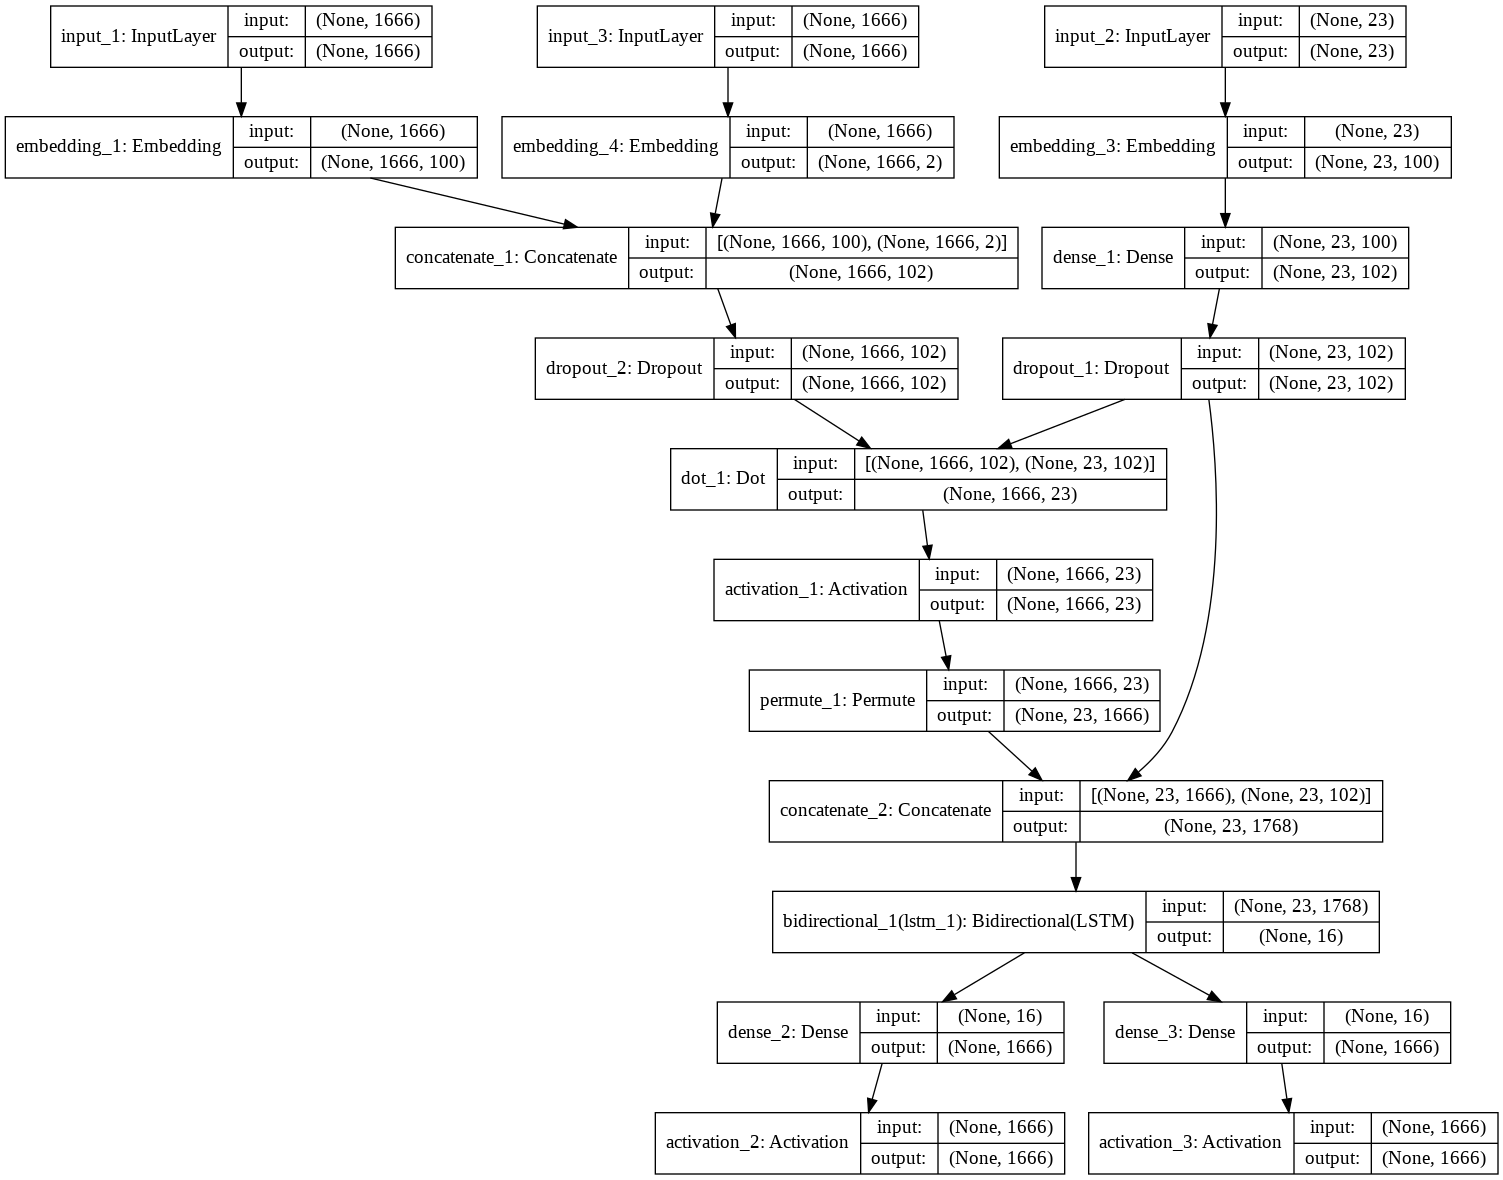

In [0]:
model_tokens_feature_extraction= create_tokens_model_with_feature_extraction_new(2,2)

# plot graph
plot_model(model_tokens_feature_extraction, to_file='bAbI.png', show_shapes=True) 
display(Image(filename='bAbI.png'))

##Train Word Match (old)

In [0]:
data_answer_tokens_based_start_with_ans.shape

(865,)

In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=30
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_tokens_word_match.h5', save_best_only=True, monitor='loss', mode='min')

history_tokens_word_match = model_tokens_word_match.fit([data_doc_with_ans, data_word_match_with_ans,data_q_with_ans], [data_answer_tokens_based_start_with_ans, data_answer_tokens_based_end_with_ans],
          batch_size=32,
          epochs=500,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
865/865 [==============================] - 4s 5ms/step - loss: 13.9926 - activation_2_loss: 7.0824 - activation_3_loss: 6.9101 - activation_2_acc: 0.0035 - activation_3_acc: 0.0601
Epoch 2/500
865/865 [==============================] - 3s 3ms/step - loss: 12.1329 - activation_2_loss: 6.1762 - activation_3_loss: 5.9567 - activation_2_acc: 0.0092 - activation_3_acc: 0.0728
Epoch 3/500
865/865 [==============================] - 3s 3ms/step - loss: 11.6492 - activation_2_loss: 5.9338 - activation_3_loss: 5.7153 - activation_2_acc: 0.0081 - activation_3_acc: 0.0728
Epoch 4/500
865/865 [==============================] - 3s 3ms/step - loss: 11.3746 - activation_2_loss: 5.7943 - activation_3_loss: 5.5803 - activation_2_acc: 0.0035 - activation_3_acc: 0.0728
Epoch 5/500
865/865 [==============================] - 3s 3ms/step - loss: 11.1483 - activation_2_loss: 5.6790 - activation_3_loss: 5.4693 - activation_2_acc: 0.0092 - activation_3_acc: 0.0728
Epoch 6/500
865/865 [==============

In [0]:
K.clear_session()

In [0]:

# save history
f = open('history_tokens_word_match.pckl', 'wb')
pickle.dump(history_tokens_word_match.history, f)
f.close()

In [0]:
#upload to Google drive
upload = upload_google_drive('history_tokens_word_match.pckl')
print('{} with ID {}'.format('history_tokens_word_match.pckl', upload.get('id')))

history_tokens_word_match.pckl with ID 1KsJyxh4VpfksoyjFgtqjORyVbkTaSGCr


In [0]:
#upload to Google drive
upload = upload_google_drive('model_tokens_word_match.h5')
print('{} with ID {}'.format('model_tokens_word_match.h5', upload.get('id')))

model_tokens_word_match.h5 with ID 19xJujOUrzlXCTFmZcGsQKAAiAkiTWY6v


##Train Word Match (new)

In [0]:
K.clear_session()
model_tokens_word_match_new= create_tokens_model_with_feature_extraction_new(2,10)


In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=30
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_tokens_word_match_new.h5', save_best_only=True, monitor='loss', mode='min')

history_tokens_word_match_new = model_tokens_word_match_new.fit([data_doc_with_ans, data_word_match_with_ans,data_q_with_ans], [data_answer_tokens_based_start_with_ans, data_answer_tokens_based_end_with_ans],
          batch_size=32,
          epochs=400,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/400
865/865 [==============================] - 4s 4ms/step - loss: 13.9710 - activation_2_loss: 7.0805 - activation_3_loss: 6.8904 - activation_2_acc: 0.0012 - activation_3_acc: 0.0647
Epoch 2/400
865/865 [==============================] - 2s 3ms/step - loss: 12.1031 - activation_2_loss: 6.1604 - activation_3_loss: 5.9427 - activation_2_acc: 0.0023 - activation_3_acc: 0.0728
Epoch 3/400
865/865 [==============================] - 2s 3ms/step - loss: 11.6310 - activation_2_loss: 5.9228 - activation_3_loss: 5.7082 - activation_2_acc: 0.0058 - activation_3_acc: 0.0728
Epoch 4/400
865/865 [==============================] - 2s 3ms/step - loss: 11.3074 - activation_2_loss: 5.7600 - activation_3_loss: 5.5474 - activation_2_acc: 0.0058 - activation_3_acc: 0.0728
Epoch 5/400
865/865 [==============================] - 3s 3ms/step - loss: 11.0424 - activation_2_loss: 5.6257 - activation_3_loss: 5.4167 - activation_2_acc: 0.0069 - activation_3_acc: 0.0728
Epoch 6/400
865/865 [==============

In [0]:
K.clear_session()
# save history
f = open('history_tokens_word_match_new.pckl', 'wb')
pickle.dump(history_tokens_word_match_new.history, f)
f.close()

#upload to Google drive
upload = upload_google_drive('history_tokens_word_match_new.pckl')
print('{} with ID {}'.format('history_tokens_word_match_new.pckl', upload.get('id')))

history_tokens_word_match_new.pckl with ID 1w7UzJUhr8S9vRsyt8HAcNxhS78vIS6hi


In [0]:
#upload to Google drive
upload = upload_google_drive('model_tokens_word_match_new.h5')
print('{} with ID {}'.format('model_tokens_word_match_new.h5', upload.get('id')))

model_tokens_word_match_new.h5 with ID 1-izLaU7fIajFQc5XLDTGYKLi2XPELMhQ


##Train POS 

In [0]:
K.clear_session()
model_tokens_pos_new= create_tokens_model_with_feature_extraction_new(64,10)


In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=15
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_tokens_pos_new.h5', save_best_only=True, monitor='loss', mode='min')

history_tokens_pos_new = model_tokens_pos_new.fit([data_doc_with_ans, data_pos_with_ans ,data_q_with_ans], [data_answer_tokens_based_start_with_ans, data_answer_tokens_based_end_with_ans],
          batch_size=32,
          epochs=300,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/300
865/865 [==============================] - 4s 4ms/step - loss: 13.9641 - activation_2_loss: 7.0646 - activation_3_loss: 6.8995 - activation_2_acc: 0.0000e+00 - activation_3_acc: 0.0671
Epoch 2/300
865/865 [==============================] - 2s 3ms/step - loss: 12.1328 - activation_2_loss: 6.1702 - activation_3_loss: 5.9626 - activation_2_acc: 0.0058 - activation_3_acc: 0.0728
Epoch 3/300
865/865 [==============================] - 2s 3ms/step - loss: 11.7296 - activation_2_loss: 5.9739 - activation_3_loss: 5.7557 - activation_2_acc: 0.0046 - activation_3_acc: 0.0728
Epoch 4/300
865/865 [==============================] - 2s 3ms/step - loss: 11.4434 - activation_2_loss: 5.8295 - activation_3_loss: 5.6139 - activation_2_acc: 0.0035 - activation_3_acc: 0.0728
Epoch 5/300
865/865 [==============================] - 2s 3ms/step - loss: 11.1931 - activation_2_loss: 5.7055 - activation_3_loss: 5.4876 - activation_2_acc: 0.0081 - activation_3_acc: 0.0728
Epoch 6/300
865/865 [==========

In [0]:
K.clear_session()
# save history
f = open('history_tokens_pos_new.pckl', 'wb')
pickle.dump(history_tokens_pos_new.history, f)
f.close()

#upload to Google drive
upload = upload_google_drive('history_tokens_pos_new.pckl')
print('{} with ID {}'.format('history_tokens_pos_new.pckl', upload.get('id')))

history_tokens_pos_new.pckl with ID 1N-b_wMrDKRPSyKJrF2QW2S5iee7UBiAo


In [0]:
#upload to Google drive
upload = upload_google_drive('model_tokens_pos_new.h5')
print('{} with ID {}'.format('model_tokens_pos_new.h5', upload.get('id')))

model_tokens_pos_new.h5 with ID 1-csFySS_Z0-pbsFi-lLq6dCTyEo5PNc6


##Train tf-idf

In [0]:
K.clear_session()
model_tokens_tf_new= create_tokens_model_with_feature_extraction_new(1666,10)



In [0]:
# train the model
early_stopping  = EarlyStopping(monitor='loss',
                              patience=15
                              , mode='auto')
model_checkpoint = ModelCheckpoint('model_tokens_tf_new.h5', save_best_only=True, monitor='loss', mode='min')

history_tokens_tf_new = model_tokens_tf_new.fit([data_doc_with_ans, data_tf_with_ans ,data_q_with_ans], [data_answer_tokens_based_start_with_ans, data_answer_tokens_based_end_with_ans],
          batch_size=32,
          epochs=300,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/300
865/865 [==============================] - 4s 4ms/step - loss: 13.9618 - activation_2_loss: 7.0834 - activation_3_loss: 6.8784 - activation_2_acc: 0.0012 - activation_3_acc: 0.0636
Epoch 2/300
865/865 [==============================] - 2s 3ms/step - loss: 12.1105 - activation_2_loss: 6.1722 - activation_3_loss: 5.9383 - activation_2_acc: 0.0058 - activation_3_acc: 0.0728
Epoch 3/300
865/865 [==============================] - 2s 3ms/step - loss: 11.6401 - activation_2_loss: 5.9342 - activation_3_loss: 5.7059 - activation_2_acc: 0.0035 - activation_3_acc: 0.0728
Epoch 4/300
865/865 [==============================] - 2s 3ms/step - loss: 11.2924 - activation_2_loss: 5.7588 - activation_3_loss: 5.5337 - activation_2_acc: 0.0092 - activation_3_acc: 0.0728
Epoch 5/300
865/865 [==============================] - 2s 3ms/step - loss: 11.0100 - activation_2_loss: 5.6169 - activation_3_loss: 5.3931 - activation_2_acc: 0.0127 - activation_3_acc: 0.0751
Epoch 6/300
865/865 [==============

In [0]:
K.clear_session()
# save history
f = open('history_tokens_tf_new.pckl', 'wb')
pickle.dump(history_tokens_tf_new.history, f)
f.close()

#upload to Google drive
upload = upload_google_drive('history_tokens_tf_new.pckl')
print('{} with ID {}'.format('history_tokens_tf_new.pckl', upload.get('id')))

history_tokens_tf_new.pckl with ID 1Wkov-_L1_6Bpt6uDfEo3wn8PhkC1zbh6


In [0]:
#upload to Google drive
upload = upload_google_drive('model_tokens_tf_new.h5')
print('{} with ID {}'.format('model_tokens_tf_new.h5', upload.get('id')))

model_tokens_tf_new.h5 with ID 1wOjrr3OAyZHj9ZxfeCTEhmT3CP8qsFES


#Predict Test set with trained Model

In [0]:
'''
The prediction work as a PIPELINE
1. Given a doc and question, predict if the doc contain answer or not by the trained Binary Model.
  If no answer print no answer to the user
  if contain answer, feed the doc and question pair to the next model
2. Given a doc and question pairs from Step 1 filtered by the trained Binary Model,
  predict start and end token position
'''

In [0]:
def print_score(y_true, y_hat):
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_true, y_hat)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_true, y_hat)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_true, y_hat)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_true, y_hat)
  print('F1 score: %f' % f1)

In [0]:
def generate_pred_binary(model, inputs):
  
  pred = model.predict(inputs)
  pred_mask = pred >= 0.5

  #pred_mask = pred_mask.flatten()
   
  
  return pred_mask

##Pipeline Word_Match (FINAL MODEL)

###Binary model as filter

In [0]:
#download_google_drive('1LKCYBeZqeNONeXwLlEJFY05L9p9sijD5', 'model_binary_word_match.h5')
#download_google_drive('1VllUrYB8_V6v78cmEdCGP1P-hsV7X6uy', 'model_binary_word_match.h5')
download_google_drive('1VllUrYB8_V6v78cmEdCGP1P-hsV7X6uy', 'model_binary_word_match.h5')
K.clear_session()

In [0]:
model_binary_word_match = load_model('model_binary_word_match.h5')

In [0]:
pred_model_binary_word_match_mask = generate_pred_binary(model_binary_word_match, [data_doc_test, data_word_match_test, data_q_test])

In [0]:
print_score(data_answer_binary_test, pred_model_binary_word_match_mask)

Accuracy: 0.595238
Precision: 0.467290
Recall: 0.414938
F1 score: 0.439560


In [0]:
K.clear_session()

###Predict start and end position 

In [0]:
assert(data_doc_test.shape[0]==data_word_match_test.shape[0]==data_q_test.shape[0])

In [0]:
#download save model
#download_google_drive('19xJujOUrzlXCTFmZcGsQKAAiAkiTWY6v', 'model_tokens_word_match.h5')
download_google_drive('1-izLaU7fIajFQc5XLDTGYKLi2XPELMhQ', 'model_tokens_word_match_new.h5')

In [0]:
model_tokens_word_match_new = load_model('model_tokens_word_match_new.h5')

In [0]:
#prediction on whole test data
pred_word_match_new = model_tokens_word_match_new.predict([data_doc_test, data_word_match_test, data_q_test]) # a list

pred_start_word_match_new = pred_word_match_new[0]
pred_end_word_match_new = pred_word_match_new[1]

pred_start_word_match_new_position = np.argmax(pred_start_word_match_new,axis=1)
pred_end_word_match_new_position = np.argmax(pred_end_word_match_new,axis=1)

In [0]:
#replace no answer dataset to [0, 0]
pred_start_word_match_new_position[pred_model_binary_word_match_mask.flatten()==False] = 0

pred_end_word_match_new_position[pred_model_binary_word_match_mask.flatten()==False] = 0


In [0]:
pred_start_word_match_new_acc_mask = pred_start_word_match_new_position == data_answer_tokens_based_start_test
pred_end_word_match_new_acc_mask = pred_end_word_match_new_position == data_answer_tokens_based_end_test

In [0]:
#test accuracy
pred_word_match_new_acc = sum(np.logical_and(pred_start_word_match_new_acc_mask, pred_end_word_match_new_acc_mask))/data_answer_tokens_based_start_test.shape[0]
pred_word_match_new_acc

0.4365079365079365

In [0]:
K.clear_session()

In [0]:
print(metrics.flat_classification_report( np.reshape(pred_start_word_match_new_position, (-1, 2)), np.reshape(data_answer_tokens_based_start_test, (-1, 2)), labels=list(range(1666))))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       416
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
print(metrics.flat_classification_report( np.reshape(pred_end_word_match_new_position, (-1, 2)), np.reshape(data_answer_tokens_based_end_test, (-1, 2)), labels=list(range(1666))))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       416
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


##Pipeline POS

###Binary model as filter

In [0]:
download_google_drive('10f6JOw0YBWSoMincvhw15-meGgOXQpIX', 'model_binary_pos.h5')
K.clear_session()
model_binary_pos = load_model('model_binary_pos.h5')


In [0]:
pred_model_binary_pos_mask = generate_pred_binary(model_binary_pos, [data_doc_test, data_pos_test, data_q_test])

In [0]:
print_score(data_answer_binary_test, pred_model_binary_pos_mask)

Accuracy: 0.549206
Precision: 0.420074
Recall: 0.468880
F1 score: 0.443137


In [0]:
K.clear_session()

###Predict start and end token

In [0]:
K.clear_session()

In [0]:
download_google_drive('1-csFySS_Z0-pbsFi-lLq6dCTyEo5PNc6', 'model_tokens_pos.h5')

In [0]:
model_tokens_pos = load_model('model_tokens_pos.h5')

In [0]:
#prediction on whole test data
pred_tokens_pos = model_tokens_pos.predict([data_doc_test, data_pos_test, data_q_test]) # a list

pred_start_pos = pred_tokens_pos[0]
pred_end_pos = pred_tokens_pos[1]

pred_start_pos_position = np.argmax(pred_start_pos,axis=1)
pred_end_pos_position = np.argmax(pred_end_pos,axis=1)

In [0]:
#replace no answer dataset to [0, 0]
pred_start_pos_position[pred_model_binary_pos_mask.flatten()==False] = 0

pred_end_pos_position[pred_model_binary_pos_mask.flatten()==False] = 0



In [0]:
pred_start_pos_acc_mask = pred_start_pos_position == data_answer_tokens_based_start_test
pred_end_pos_acc_mask = pred_end_pos_position == data_answer_tokens_based_end_test

In [0]:
#test accuracy
pred_pos_acc = sum(np.logical_and(pred_start_pos_acc_mask, pred_end_pos_acc_mask))/data_answer_tokens_based_start_test.shape[0]
pred_pos_acc

0.38412698412698415

In [0]:
print(metrics.flat_classification_report( np.reshape(pred_start_pos_position, (-1, 2)), np.reshape(data_answer_tokens_based_start_test, (-1, 2)), labels=list(range(1666))))

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       358
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
print(metrics.flat_classification_report( np.reshape(pred_end_pos_position, (-1, 2)), np.reshape(data_answer_tokens_based_end_test, (-1, 2)), labels=list(range(1666))))

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       358
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
K.clear_session()

##Pipeline TF-IDF

###Binary model as filter

In [0]:
K.clear_session()

In [0]:
download_google_drive('1az7cReWDnLKj1mLfzXzmZU_mUa4_gOXS', 'model_binary_tf.h5')
K.clear_session()
model_binary_tf = load_model('model_binary_tf.h5')



In [0]:
pred_model_binary_tf_mask = generate_pred_binary(model_binary_tf, [data_doc_test, data_tf_test, data_q_test])

In [0]:
print_score(data_answer_binary_test, pred_model_binary_tf_mask)

Accuracy: 0.573016
Precision: 0.453642
Recall: 0.568465
F1 score: 0.504604


###Predict start and end token

In [0]:
K.clear_session()

In [0]:
download_google_drive('1wOjrr3OAyZHj9ZxfeCTEhmT3CP8qsFES', 'model_tokens_tf.h5')
model_tokens_tf = load_model('model_tokens_tf.h5')

In [0]:
#prediction on whole test data
pred_tokens_tf = model_tokens_tf.predict([data_doc_test, data_tf_test, data_q_test]) # a list

pred_start_tf = pred_tokens_tf[0]
pred_end_tf = pred_tokens_tf[1]

pred_start_tf_position = np.argmax(pred_start_tf,axis=1)
pred_end_tf_position = np.argmax(pred_end_tf,axis=1)

In [0]:
#replace no answer dataset to [0, 0]
pred_start_tf_position[pred_model_binary_tf_mask.flatten()==False] = 0

pred_end_tf_position[pred_model_binary_tf_mask.flatten()==False] = 0




In [0]:
pred_start_tf_acc_mask = pred_start_tf_position == data_answer_tokens_based_start_test
pred_end_tf_acc_mask = pred_end_tf_position == data_answer_tokens_based_end_test

In [0]:
#test accuracy
pred_tf_acc = sum(np.logical_and(pred_start_tf_acc_mask, pred_end_tf_acc_mask))/data_answer_tokens_based_start_test.shape[0]
pred_tf_acc

0.35555555555555557

In [0]:
print(metrics.flat_classification_report( np.reshape(pred_start_tf_position, (-1, 2)), np.reshape(data_answer_tokens_based_start_test, (-1, 2)), labels=list(range(1666))))

              precision    recall  f1-score   support

           0       0.58      0.68      0.62       328
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
print(metrics.flat_classification_report( np.reshape(pred_end_tf_position, (-1, 2)), np.reshape(data_answer_tokens_based_end_test, (-1, 2)), labels=list(range(1666))))

              precision    recall  f1-score   support

           0       0.58      0.68      0.62       328
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


##Compute predicted answer for test set

In [0]:
'''
1. extract sentence sequence based on start and end positions
2. compute precision, recall, f1

extra: convert sentence sequence to sentence tokens
'''

###extract sentence sequence based on start and end positions

In [0]:
data_doc_test.shape

(630, 1666)

###convert sentence sequence to sentence tokens


In [0]:
for d in data_doc_test[1][pred_start_pos[1]:pred_end_pos[1]+1]:
  if d !=0:
    print(reverse_token_map[d])

a
prison
from
old
french
prisoun
also
known
as
gaol
or
jail
is
a
place
in
which
people
are
physically
confined
and
usually
deprived
of
a
range
of
personal
freedoms
imprisonment
or
incarceration
is
a
legal
penalty
that
may
be
imposed
by
the
state
for
the
commission
of
a
crime
